In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from functools import partial
from itertools import combinations

import numpy as np
import jax
from jax import random
from jax import numpy as jnp
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
import distrax
import wandb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import src.models as models
from src.models import make_PoG_Ens_loss, make_Reg_Ens_loss, make_PoN_Ens_loss
from src.models import make_PoG_Ens_plots, make_Reg_Ens_plots, make_PoN_Ens_plots
import src.data
from src.data import NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.comparison_figures_pog import get_config as get_pog_config
from experiments.configs.comparison_figures_reg_ens import get_config as get_reg_ens_config
from experiments.configs.comparison_figures_pon import get_config as get_pon_config
from src.models.pog import calculate_pog_loc_scale
from src.models.reg_ens import calculate_ens_loc_scale
from src.models.pon import normal_prod

In [3]:
RETRAIN = True

In [4]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'reg_comparison_figures.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


True

## PoG Training

In [5]:
config = get_pog_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_pog_states = []
for i in range(3):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    pog_model, state = setup_training(config, setup_rng, init_x, init_y)

    if False:  # RETRAIN
        state, best_state = train_loop(
            pog_model, state, config, rng, make_PoG_Ens_loss, make_PoG_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_PoG_Ens_plots,
        )

        best_pog_states.append(best_state)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

In [6]:
if False:  # RETRAIN
    save_checkpoint('pog_models', best_pog_states, 1)

## Reg Ens training

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 9.37653, val_loss: 8.40483, lr: 0.00010


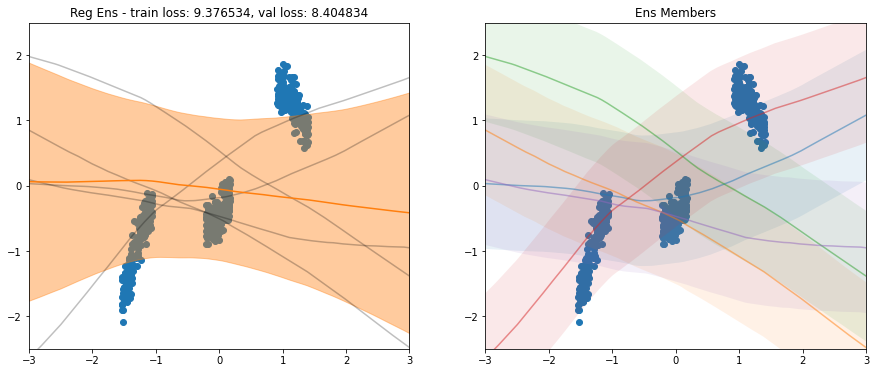

Best val_loss
epoch:   2 - train loss: 9.07656, val_loss: 8.41471, lr: 0.00010
epoch:   3 - train loss: 8.79701, val_loss: 8.40264, lr: 0.00010
Best val_loss
epoch:   4 - train loss: 8.54451, val_loss: 8.37102, lr: 0.00010
Best val_loss
epoch:   5 - train loss: 8.26969, val_loss: 8.32107, lr: 0.00010
Best val_loss
epoch:   6 - train loss: 7.97982, val_loss: 8.25451, lr: 0.00010
Best val_loss
epoch:   7 - train loss: 7.68742, val_loss: 8.16831, lr: 0.00010
Best val_loss
epoch:   8 - train loss: 7.41255, val_loss: 8.07020, lr: 0.00010
Best val_loss
epoch:   9 - train loss: 7.16131, val_loss: 7.96319, lr: 0.00010
Best val_loss
epoch:  10 - train loss: 6.93225, val_loss: 7.84935, lr: 0.00010
Best val_loss
epoch:  11 - train loss: 6.72908, val_loss: 7.73126, lr: 0.00010
Best val_loss
epoch:  12 - train loss: 6.55298, val_loss: 7.61064, lr: 0.00010
Best val_loss
epoch:  13 - train loss: 6.39774, val_loss: 7.48967, lr: 0.00010
Best val_loss
epoch:  14 - train loss: 6.27311, val_loss: 7.36955,

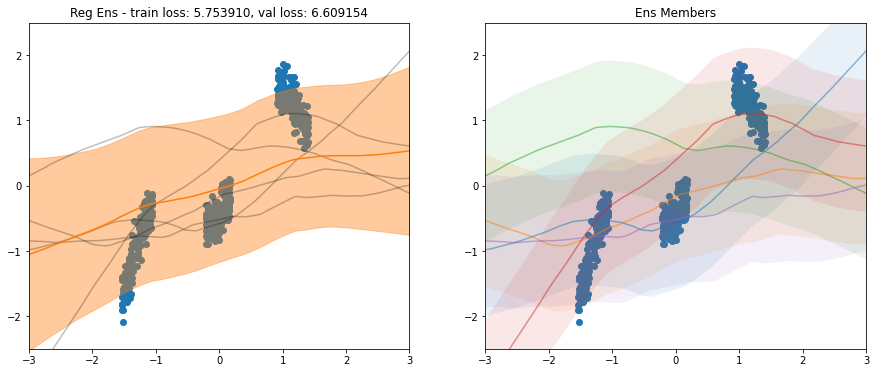

Best val_loss
epoch:  22 - train loss: 5.71226, val_loss: 6.51877, lr: 0.00010
Best val_loss
epoch:  23 - train loss: 5.67303, val_loss: 6.43374, lr: 0.00010
Best val_loss
epoch:  24 - train loss: 5.63590, val_loss: 6.35347, lr: 0.00010
Best val_loss
epoch:  25 - train loss: 5.59951, val_loss: 6.27758, lr: 0.00010
Best val_loss
epoch:  26 - train loss: 5.56341, val_loss: 6.20542, lr: 0.00010
Best val_loss
epoch:  27 - train loss: 5.52694, val_loss: 6.13683, lr: 0.00010
Best val_loss
epoch:  28 - train loss: 5.48996, val_loss: 6.07186, lr: 0.00010
Best val_loss
epoch:  29 - train loss: 5.45231, val_loss: 6.01016, lr: 0.00010
Best val_loss
epoch:  30 - train loss: 5.41391, val_loss: 5.95141, lr: 0.00010
Best val_loss
epoch:  31 - train loss: 5.37520, val_loss: 5.89578, lr: 0.00010
Best val_loss
epoch:  32 - train loss: 5.33607, val_loss: 5.84288, lr: 0.00010
Best val_loss
epoch:  33 - train loss: 5.29692, val_loss: 5.79241, lr: 0.00010
Best val_loss
epoch:  34 - train loss: 5.25773, val_

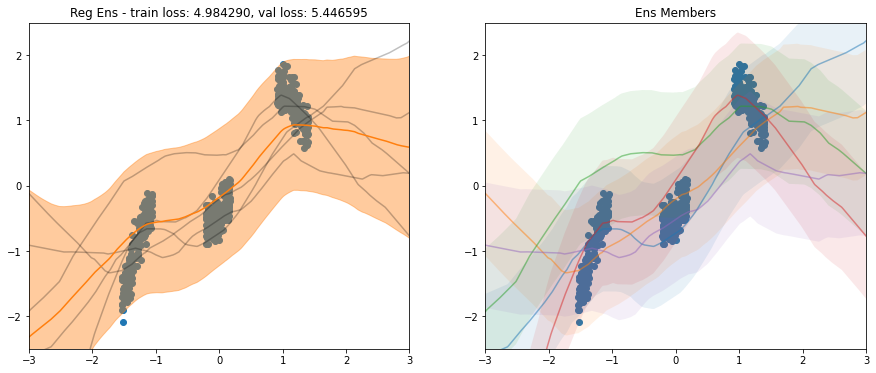

Best val_loss
epoch:  42 - train loss: 4.94762, val_loss: 5.40734, lr: 0.00010
Best val_loss
epoch:  43 - train loss: 4.91120, val_loss: 5.36802, lr: 0.00010
Best val_loss
epoch:  44 - train loss: 4.87599, val_loss: 5.32854, lr: 0.00010
Best val_loss
epoch:  45 - train loss: 4.84141, val_loss: 5.28888, lr: 0.00010
Best val_loss
epoch:  46 - train loss: 4.80728, val_loss: 5.24903, lr: 0.00010
Best val_loss
epoch:  47 - train loss: 4.77394, val_loss: 5.20948, lr: 0.00010
Best val_loss
epoch:  48 - train loss: 4.74109, val_loss: 5.16947, lr: 0.00010
Best val_loss
epoch:  49 - train loss: 4.70881, val_loss: 5.12844, lr: 0.00010
Best val_loss
epoch:  50 - train loss: 4.67698, val_loss: 5.08652, lr: 0.00010
Best val_loss
epoch:  51 - train loss: 4.64553, val_loss: 5.04385, lr: 0.00010
Best val_loss
epoch:  52 - train loss: 4.61453, val_loss: 5.00125, lr: 0.00010
Best val_loss
epoch:  53 - train loss: 4.58401, val_loss: 4.95939, lr: 0.00010
Best val_loss
epoch:  54 - train loss: 4.55379, val_

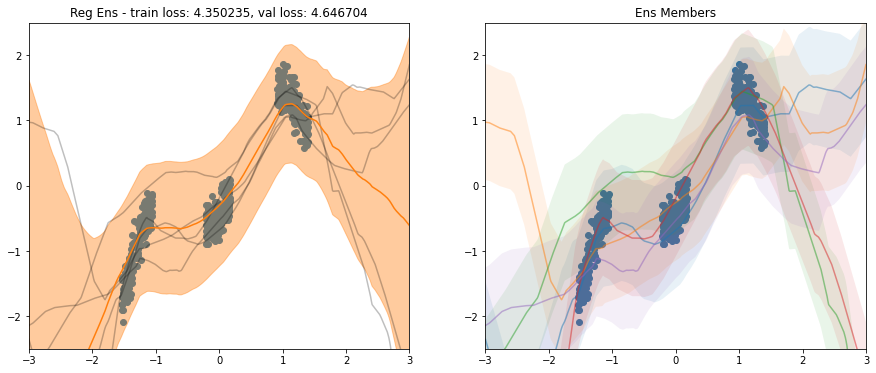

Best val_loss
epoch:  62 - train loss: 4.32201, val_loss: 4.60907, lr: 0.00010
Best val_loss
epoch:  63 - train loss: 4.29400, val_loss: 4.57174, lr: 0.00010
Best val_loss
epoch:  64 - train loss: 4.26620, val_loss: 4.53462, lr: 0.00010
Best val_loss
epoch:  65 - train loss: 4.23872, val_loss: 4.49771, lr: 0.00010
Best val_loss
epoch:  66 - train loss: 4.21131, val_loss: 4.46096, lr: 0.00010
Best val_loss
epoch:  67 - train loss: 4.18413, val_loss: 4.42418, lr: 0.00010
Best val_loss
epoch:  68 - train loss: 4.15724, val_loss: 4.38712, lr: 0.00010
Best val_loss
epoch:  69 - train loss: 4.13049, val_loss: 4.35005, lr: 0.00010
Best val_loss
epoch:  70 - train loss: 4.10382, val_loss: 4.31351, lr: 0.00010
Best val_loss
epoch:  71 - train loss: 4.07729, val_loss: 4.27770, lr: 0.00010
Best val_loss
epoch:  72 - train loss: 4.05086, val_loss: 4.24235, lr: 0.00010
Best val_loss
epoch:  73 - train loss: 4.02463, val_loss: 4.20725, lr: 0.00010
Best val_loss
epoch:  74 - train loss: 3.99866, val_

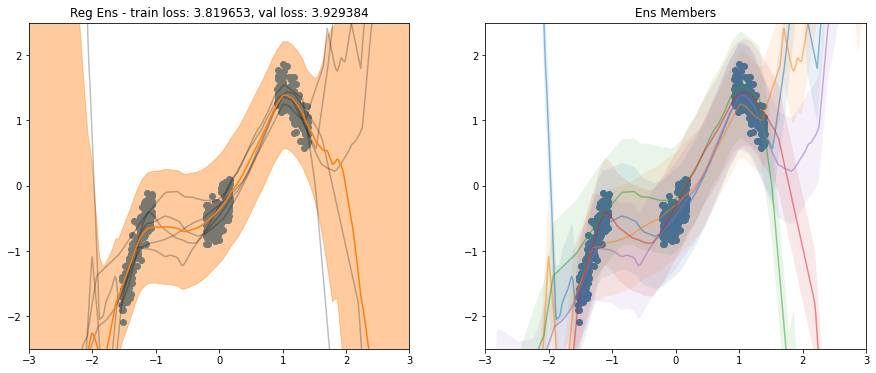

Best val_loss
epoch:  82 - train loss: 3.79442, val_loss: 3.89760, lr: 0.00010
Best val_loss
epoch:  83 - train loss: 3.76916, val_loss: 3.86691, lr: 0.00010
Best val_loss
epoch:  84 - train loss: 3.74408, val_loss: 3.83732, lr: 0.00010
Best val_loss
epoch:  85 - train loss: 3.71891, val_loss: 3.80867, lr: 0.00010
Best val_loss
epoch:  86 - train loss: 3.69375, val_loss: 3.78060, lr: 0.00010
Best val_loss
epoch:  87 - train loss: 3.66853, val_loss: 3.75308, lr: 0.00010
Best val_loss
epoch:  88 - train loss: 3.64321, val_loss: 3.72602, lr: 0.00010
Best val_loss
epoch:  89 - train loss: 3.61768, val_loss: 3.69941, lr: 0.00010
Best val_loss
epoch:  90 - train loss: 3.59198, val_loss: 3.67351, lr: 0.00010
Best val_loss
epoch:  91 - train loss: 3.56625, val_loss: 3.64809, lr: 0.00010
Best val_loss
epoch:  92 - train loss: 3.54037, val_loss: 3.62340, lr: 0.00010
Best val_loss
epoch:  93 - train loss: 3.51545, val_loss: 3.59932, lr: 0.00010
Best val_loss
epoch:  94 - train loss: 3.49219, val_

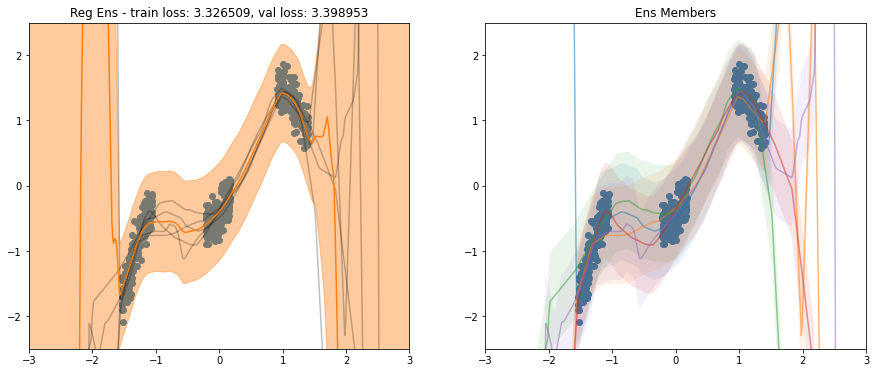

Best val_loss
epoch: 102 - train loss: 3.30396, val_loss: 3.37524, lr: 0.00010
Best val_loss
epoch: 103 - train loss: 3.28093, val_loss: 3.35178, lr: 0.00010
Best val_loss
epoch: 104 - train loss: 3.25750, val_loss: 3.32849, lr: 0.00010
Best val_loss
epoch: 105 - train loss: 3.23345, val_loss: 3.30535, lr: 0.00010
Best val_loss
epoch: 106 - train loss: 3.20957, val_loss: 3.28236, lr: 0.00010
Best val_loss
epoch: 107 - train loss: 3.18652, val_loss: 3.25957, lr: 0.00010
Best val_loss
epoch: 108 - train loss: 3.16428, val_loss: 3.23621, lr: 0.00010
Best val_loss
epoch: 109 - train loss: 3.14176, val_loss: 3.21259, lr: 0.00010
Best val_loss
epoch: 110 - train loss: 3.11877, val_loss: 3.18964, lr: 0.00010
Best val_loss
epoch: 111 - train loss: 3.09522, val_loss: 3.16733, lr: 0.00010
Best val_loss
epoch: 112 - train loss: 3.07197, val_loss: 3.14567, lr: 0.00010
Best val_loss
epoch: 113 - train loss: 3.04942, val_loss: 3.12399, lr: 0.00010
Best val_loss
epoch: 114 - train loss: 3.02711, val_

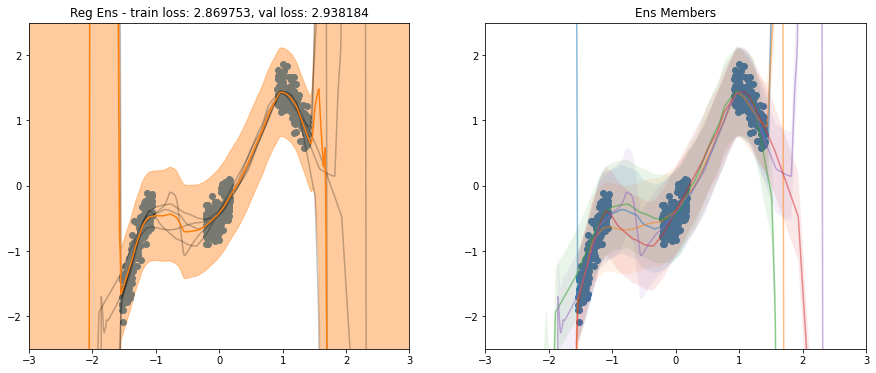

Best val_loss
epoch: 122 - train loss: 2.84718, val_loss: 2.91618, lr: 0.00010
Best val_loss
epoch: 123 - train loss: 2.82501, val_loss: 2.89430, lr: 0.00010
Best val_loss
epoch: 124 - train loss: 2.80296, val_loss: 2.87232, lr: 0.00010
Best val_loss
epoch: 125 - train loss: 2.78108, val_loss: 2.84947, lr: 0.00010
Best val_loss
epoch: 126 - train loss: 2.75919, val_loss: 2.82520, lr: 0.00010
Best val_loss
epoch: 127 - train loss: 2.73709, val_loss: 2.80053, lr: 0.00010
Best val_loss
epoch: 128 - train loss: 2.71516, val_loss: 2.77597, lr: 0.00010
Best val_loss
epoch: 129 - train loss: 2.69336, val_loss: 2.75185, lr: 0.00010
Best val_loss
epoch: 130 - train loss: 2.67167, val_loss: 2.72816, lr: 0.00010
Best val_loss
epoch: 131 - train loss: 2.65004, val_loss: 2.70498, lr: 0.00010
Best val_loss
epoch: 132 - train loss: 2.62829, val_loss: 2.68225, lr: 0.00010
Best val_loss
epoch: 133 - train loss: 2.60668, val_loss: 2.65957, lr: 0.00010
Best val_loss
epoch: 134 - train loss: 2.58522, val_

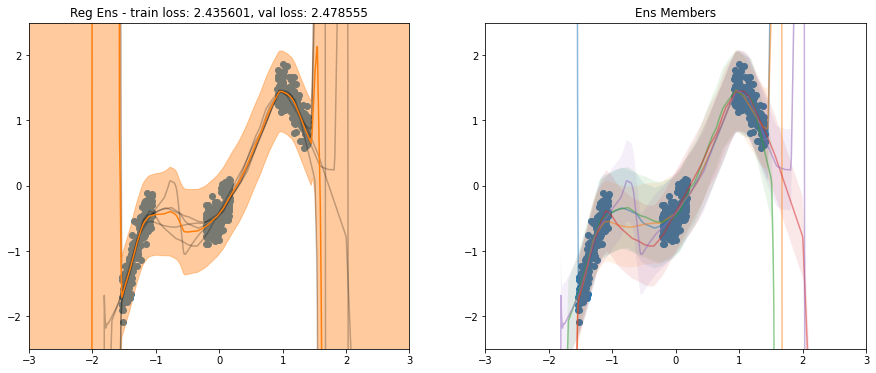

Best val_loss
epoch: 142 - train loss: 2.41423, val_loss: 2.45712, lr: 0.00010
Best val_loss
epoch: 143 - train loss: 2.39303, val_loss: 2.43582, lr: 0.00010
Best val_loss
epoch: 144 - train loss: 2.37190, val_loss: 2.41454, lr: 0.00010
Best val_loss
epoch: 145 - train loss: 2.35075, val_loss: 2.39366, lr: 0.00010
Best val_loss
epoch: 146 - train loss: 2.32954, val_loss: 2.37275, lr: 0.00010
Best val_loss
epoch: 147 - train loss: 2.30829, val_loss: 2.35172, lr: 0.00010
Best val_loss
epoch: 148 - train loss: 2.28728, val_loss: 2.33051, lr: 0.00010
Best val_loss
epoch: 149 - train loss: 2.26625, val_loss: 2.30941, lr: 0.00010
Best val_loss
epoch: 150 - train loss: 2.24531, val_loss: 2.28894, lr: 0.00010
Best val_loss
epoch: 151 - train loss: 2.22421, val_loss: 2.26902, lr: 0.00010
Best val_loss
epoch: 152 - train loss: 2.20331, val_loss: 2.24906, lr: 0.00010
Best val_loss
epoch: 153 - train loss: 2.18248, val_loss: 2.22875, lr: 0.00010
Best val_loss
epoch: 154 - train loss: 2.16156, val_

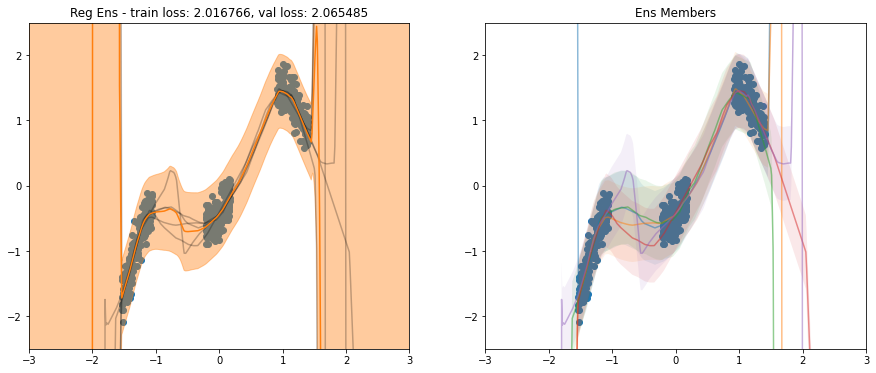

Best val_loss
epoch: 162 - train loss: 1.99640, val_loss: 2.04541, lr: 0.00010
Best val_loss
epoch: 163 - train loss: 1.97598, val_loss: 2.02572, lr: 0.00010
Best val_loss
epoch: 164 - train loss: 1.95550, val_loss: 2.00625, lr: 0.00010
Best val_loss
epoch: 165 - train loss: 1.93499, val_loss: 1.98650, lr: 0.00010
Best val_loss
epoch: 166 - train loss: 1.91454, val_loss: 1.96611, lr: 0.00010
Best val_loss
epoch: 167 - train loss: 1.89409, val_loss: 1.94599, lr: 0.00010
Best val_loss
epoch: 168 - train loss: 1.87381, val_loss: 1.92710, lr: 0.00010
Best val_loss
epoch: 169 - train loss: 1.85352, val_loss: 1.90861, lr: 0.00010
Best val_loss
epoch: 170 - train loss: 1.83335, val_loss: 1.88946, lr: 0.00010
Best val_loss
epoch: 171 - train loss: 1.81323, val_loss: 1.86897, lr: 0.00010
Best val_loss
epoch: 172 - train loss: 1.79290, val_loss: 1.84891, lr: 0.00010
Best val_loss
epoch: 173 - train loss: 1.77283, val_loss: 1.82967, lr: 0.00010
Best val_loss
epoch: 174 - train loss: 1.75276, val_

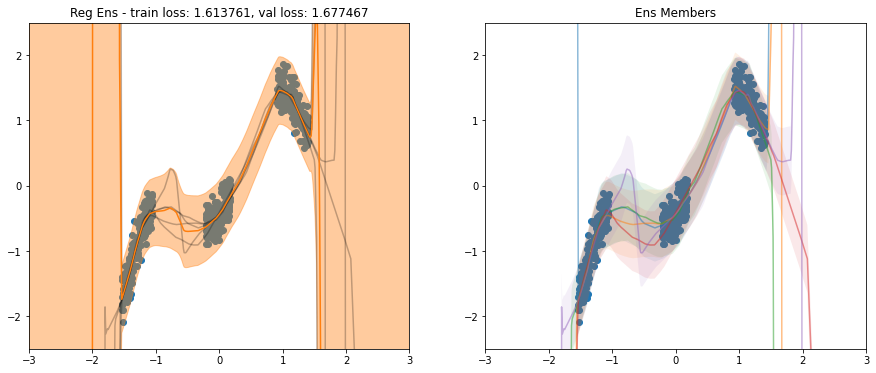

Best val_loss
epoch: 182 - train loss: 1.59406, val_loss: 1.65871, lr: 0.00010
Best val_loss
epoch: 183 - train loss: 1.57435, val_loss: 1.63924, lr: 0.00010
Best val_loss
epoch: 184 - train loss: 1.55461, val_loss: 1.61946, lr: 0.00010
Best val_loss
epoch: 185 - train loss: 1.53495, val_loss: 1.60009, lr: 0.00010
Best val_loss
epoch: 186 - train loss: 1.51548, val_loss: 1.58113, lr: 0.00010
Best val_loss
epoch: 187 - train loss: 1.49601, val_loss: 1.56237, lr: 0.00010
Best val_loss
epoch: 188 - train loss: 1.47661, val_loss: 1.54384, lr: 0.00010
Best val_loss
epoch: 189 - train loss: 1.45723, val_loss: 1.52535, lr: 0.00010
Best val_loss
epoch: 190 - train loss: 1.43786, val_loss: 1.50707, lr: 0.00010
Best val_loss
epoch: 191 - train loss: 1.41858, val_loss: 1.48873, lr: 0.00010
Best val_loss
epoch: 192 - train loss: 1.39941, val_loss: 1.47013, lr: 0.00010
Best val_loss
epoch: 193 - train loss: 1.38012, val_loss: 1.45125, lr: 0.00010
Best val_loss
epoch: 194 - train loss: 1.36102, val_

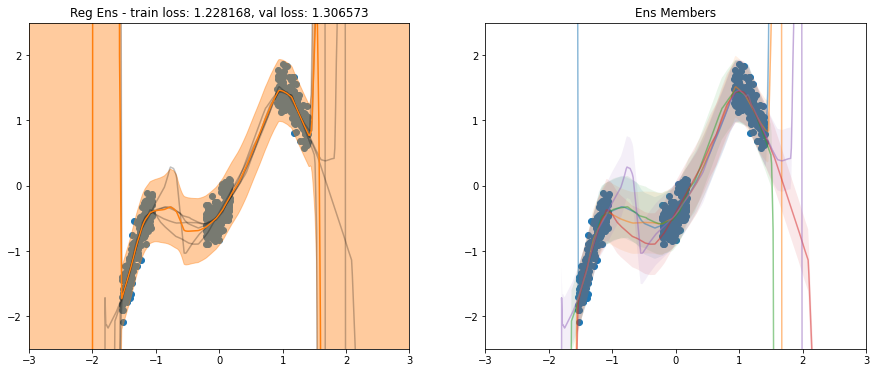

Best val_loss


+---------------------------------------------+----------+-------+----------+--------+
| Name                                        | Shape    | Size  | Mean     | Std    |
+---------------------------------------------+----------+-------+----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_2/layer_0/BatchNorm_0/me

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 9.22971, val_loss: 7.38362, lr: 0.00010


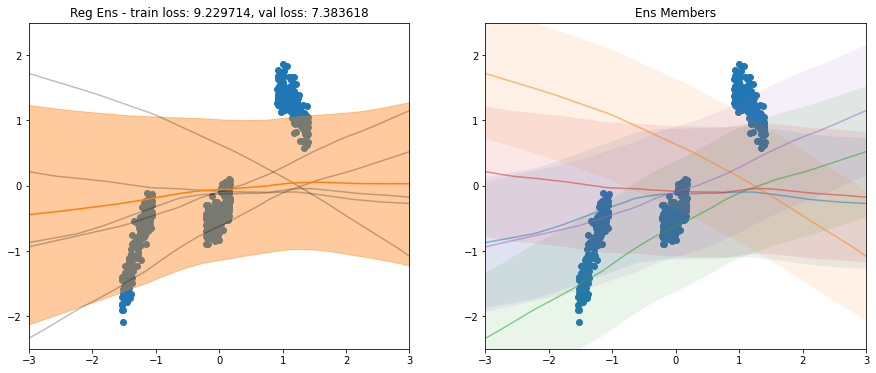

Best val_loss
epoch:   2 - train loss: 9.06075, val_loss: 7.42002, lr: 0.00010
epoch:   3 - train loss: 8.97475, val_loss: 7.44261, lr: 0.00010
epoch:   4 - train loss: 8.86969, val_loss: 7.45007, lr: 0.00010
epoch:   5 - train loss: 8.40386, val_loss: 7.44538, lr: 0.00010
epoch:   6 - train loss: 8.21028, val_loss: 7.42958, lr: 0.00010
epoch:   7 - train loss: 8.00734, val_loss: 7.40402, lr: 0.00010
epoch:   8 - train loss: 7.78386, val_loss: 7.37025, lr: 0.00010
Best val_loss
epoch:   9 - train loss: 7.57154, val_loss: 7.33011, lr: 0.00010
Best val_loss
epoch:  10 - train loss: 7.38495, val_loss: 7.28575, lr: 0.00010
Best val_loss
epoch:  11 - train loss: 7.20874, val_loss: 7.23787, lr: 0.00010
Best val_loss
epoch:  12 - train loss: 7.04218, val_loss: 7.18718, lr: 0.00010
Best val_loss
epoch:  13 - train loss: 6.88811, val_loss: 7.13452, lr: 0.00010
Best val_loss
epoch:  14 - train loss: 6.74764, val_loss: 7.08030, lr: 0.00010
Best val_loss
epoch:  15 - train loss: 6.62065, val_loss:

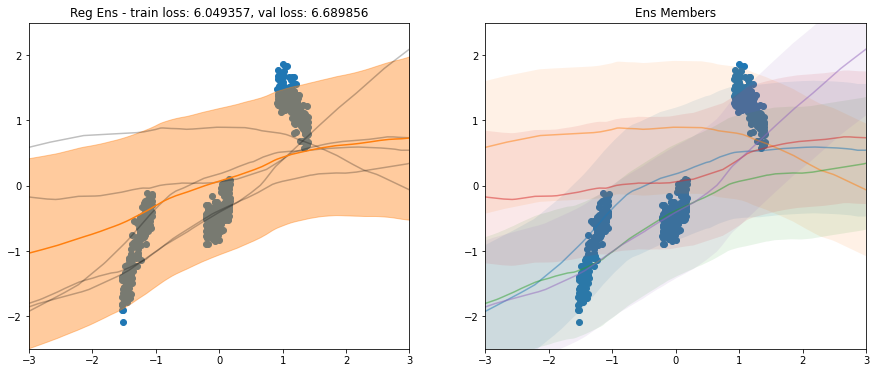

Best val_loss
epoch:  22 - train loss: 6.00391, val_loss: 6.63804, lr: 0.00010
Best val_loss
epoch:  23 - train loss: 5.96108, val_loss: 6.58849, lr: 0.00010
Best val_loss
epoch:  24 - train loss: 5.91953, val_loss: 6.54098, lr: 0.00010
Best val_loss
epoch:  25 - train loss: 5.87823, val_loss: 6.49575, lr: 0.00010
Best val_loss
epoch:  26 - train loss: 5.83505, val_loss: 6.45321, lr: 0.00010
Best val_loss
epoch:  27 - train loss: 5.78132, val_loss: 6.41337, lr: 0.00010
Best val_loss
epoch:  28 - train loss: 5.74013, val_loss: 6.37548, lr: 0.00010
Best val_loss
epoch:  29 - train loss: 5.69902, val_loss: 6.33962, lr: 0.00010
Best val_loss
epoch:  30 - train loss: 5.65593, val_loss: 6.30604, lr: 0.00010
Best val_loss
epoch:  31 - train loss: 5.61068, val_loss: 6.27440, lr: 0.00010
Best val_loss
epoch:  32 - train loss: 5.57290, val_loss: 6.24351, lr: 0.00010
Best val_loss
epoch:  33 - train loss: 5.53955, val_loss: 6.21195, lr: 0.00010
Best val_loss
epoch:  34 - train loss: 5.50927, val_

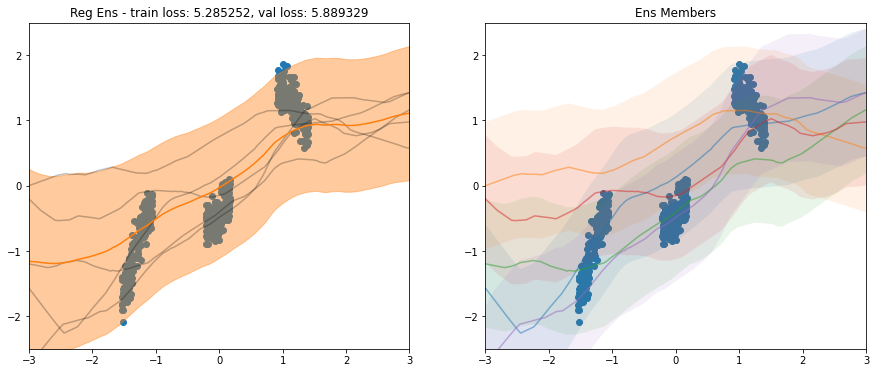

Best val_loss
epoch:  42 - train loss: 5.25235, val_loss: 5.84505, lr: 0.00010
Best val_loss
epoch:  43 - train loss: 5.21948, val_loss: 5.79966, lr: 0.00010
Best val_loss
epoch:  44 - train loss: 5.18674, val_loss: 5.75288, lr: 0.00010
Best val_loss
epoch:  45 - train loss: 5.15352, val_loss: 5.70483, lr: 0.00010
Best val_loss
epoch:  46 - train loss: 5.12071, val_loss: 5.65604, lr: 0.00010
Best val_loss
epoch:  47 - train loss: 5.09245, val_loss: 5.60518, lr: 0.00010
Best val_loss
epoch:  48 - train loss: 5.05821, val_loss: 5.55601, lr: 0.00010
Best val_loss
epoch:  49 - train loss: 5.02780, val_loss: 5.51039, lr: 0.00010
Best val_loss
epoch:  50 - train loss: 4.99551, val_loss: 5.46809, lr: 0.00010
Best val_loss
epoch:  51 - train loss: 4.96050, val_loss: 5.42739, lr: 0.00010
Best val_loss
epoch:  52 - train loss: 4.93132, val_loss: 5.38852, lr: 0.00010
Best val_loss
epoch:  53 - train loss: 4.90170, val_loss: 5.35083, lr: 0.00010
Best val_loss
epoch:  54 - train loss: 4.87180, val_

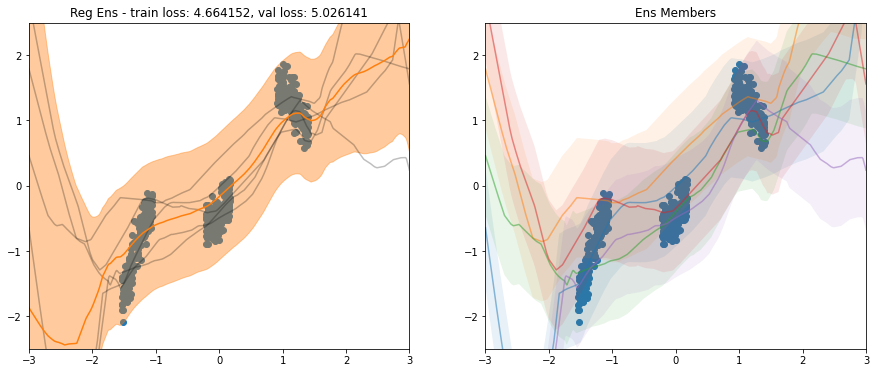

Best val_loss
epoch:  62 - train loss: 4.63571, val_loss: 4.98195, lr: 0.00010
Best val_loss
epoch:  63 - train loss: 4.60850, val_loss: 4.93744, lr: 0.00010
Best val_loss
epoch:  64 - train loss: 4.58051, val_loss: 4.89374, lr: 0.00010
Best val_loss
epoch:  65 - train loss: 4.55351, val_loss: 4.85166, lr: 0.00010
Best val_loss
epoch:  66 - train loss: 4.52685, val_loss: 4.81131, lr: 0.00010
Best val_loss
epoch:  67 - train loss: 4.50009, val_loss: 4.77300, lr: 0.00010
Best val_loss
epoch:  68 - train loss: 4.47271, val_loss: 4.73675, lr: 0.00010
Best val_loss
epoch:  69 - train loss: 4.44529, val_loss: 4.70220, lr: 0.00010
Best val_loss
epoch:  70 - train loss: 4.41738, val_loss: 4.66882, lr: 0.00010
Best val_loss
epoch:  71 - train loss: 4.38987, val_loss: 4.63610, lr: 0.00010
Best val_loss
epoch:  72 - train loss: 4.36264, val_loss: 4.60344, lr: 0.00010
Best val_loss
epoch:  73 - train loss: 4.33578, val_loss: 4.57092, lr: 0.00010
Best val_loss
epoch:  74 - train loss: 4.30876, val_

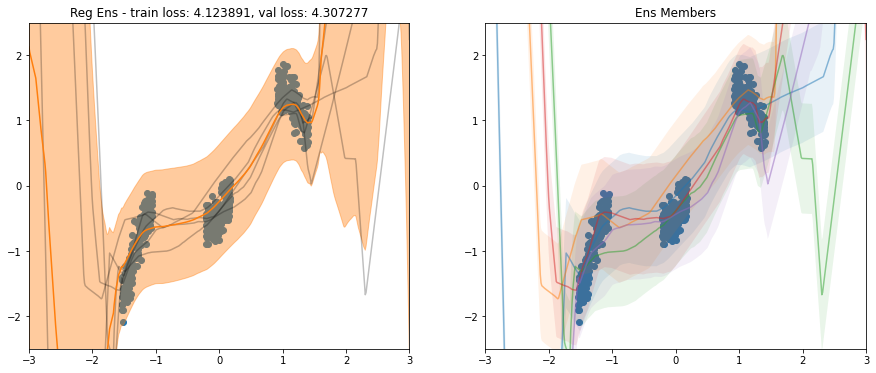

Best val_loss
epoch:  82 - train loss: 4.09782, val_loss: 4.27758, lr: 0.00010
Best val_loss
epoch:  83 - train loss: 4.07195, val_loss: 4.24621, lr: 0.00010
Best val_loss
epoch:  84 - train loss: 4.04609, val_loss: 4.21328, lr: 0.00010
Best val_loss
epoch:  85 - train loss: 4.02032, val_loss: 4.18113, lr: 0.00010
Best val_loss
epoch:  86 - train loss: 3.99461, val_loss: 4.15008, lr: 0.00010
Best val_loss
epoch:  87 - train loss: 3.96911, val_loss: 4.11989, lr: 0.00010
Best val_loss
epoch:  88 - train loss: 3.94378, val_loss: 4.08986, lr: 0.00010
Best val_loss
epoch:  89 - train loss: 3.92322, val_loss: 4.05936, lr: 0.00010
Best val_loss
epoch:  90 - train loss: 3.89390, val_loss: 4.02959, lr: 0.00010
Best val_loss
epoch:  91 - train loss: 3.86929, val_loss: 4.00036, lr: 0.00010
Best val_loss
epoch:  92 - train loss: 3.84499, val_loss: 3.97150, lr: 0.00010
Best val_loss
epoch:  93 - train loss: 3.82071, val_loss: 3.94275, lr: 0.00010
Best val_loss
epoch:  94 - train loss: 3.79658, val_

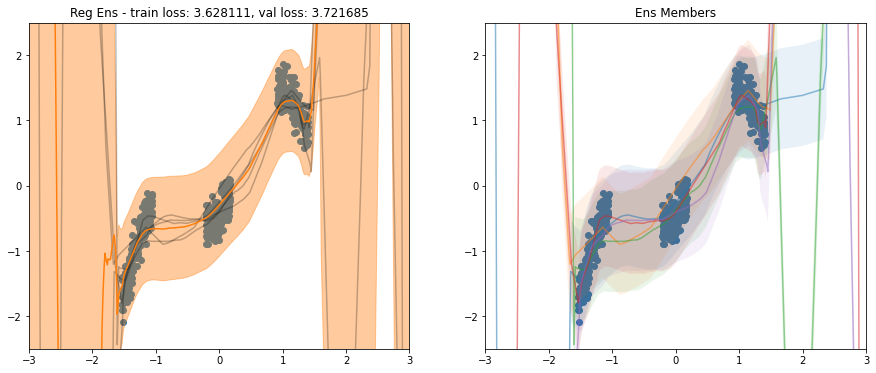

Best val_loss
epoch: 102 - train loss: 3.60427, val_loss: 3.69700, lr: 0.00010
Best val_loss
epoch: 103 - train loss: 3.58035, val_loss: 3.67279, lr: 0.00010
Best val_loss
epoch: 104 - train loss: 3.55633, val_loss: 3.64946, lr: 0.00010
Best val_loss
epoch: 105 - train loss: 3.53250, val_loss: 3.62678, lr: 0.00010
Best val_loss
epoch: 106 - train loss: 3.50862, val_loss: 3.60445, lr: 0.00010
Best val_loss
epoch: 107 - train loss: 3.48477, val_loss: 3.58201, lr: 0.00010
Best val_loss
epoch: 108 - train loss: 3.46111, val_loss: 3.55919, lr: 0.00010
Best val_loss
epoch: 109 - train loss: 3.43761, val_loss: 3.53583, lr: 0.00010
Best val_loss
epoch: 110 - train loss: 3.41420, val_loss: 3.51234, lr: 0.00010
Best val_loss
epoch: 111 - train loss: 3.39077, val_loss: 3.48830, lr: 0.00010
Best val_loss
epoch: 112 - train loss: 3.36752, val_loss: 3.46279, lr: 0.00010
Best val_loss
epoch: 113 - train loss: 3.34415, val_loss: 3.43698, lr: 0.00010
Best val_loss
epoch: 114 - train loss: 3.32077, val_

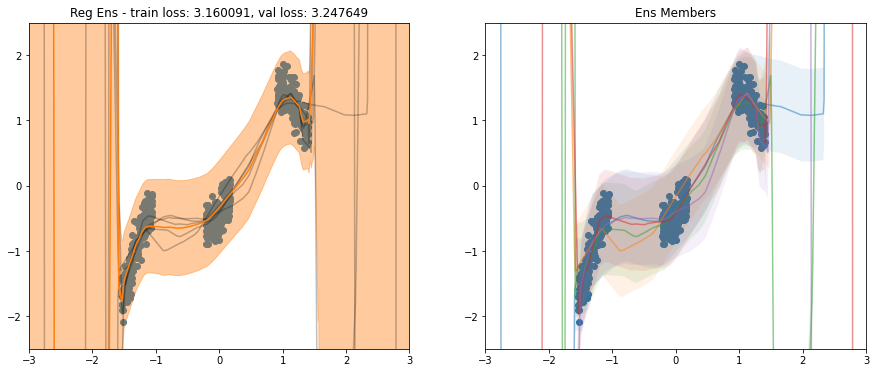

Best val_loss
epoch: 122 - train loss: 3.13778, val_loss: 3.22459, lr: 0.00010
Best val_loss
epoch: 123 - train loss: 3.11522, val_loss: 3.20096, lr: 0.00010
Best val_loss
epoch: 124 - train loss: 3.09278, val_loss: 3.17687, lr: 0.00010
Best val_loss
epoch: 125 - train loss: 3.07009, val_loss: 3.15343, lr: 0.00010
Best val_loss
epoch: 126 - train loss: 3.04755, val_loss: 3.12956, lr: 0.00010
Best val_loss
epoch: 127 - train loss: 3.02532, val_loss: 3.10516, lr: 0.00010
Best val_loss
epoch: 128 - train loss: 3.00270, val_loss: 3.08105, lr: 0.00010
Best val_loss
epoch: 129 - train loss: 2.98045, val_loss: 3.05685, lr: 0.00010
Best val_loss
epoch: 130 - train loss: 2.95805, val_loss: 3.03312, lr: 0.00010
Best val_loss
epoch: 131 - train loss: 2.93558, val_loss: 3.01145, lr: 0.00010
Best val_loss
epoch: 132 - train loss: 2.91352, val_loss: 2.98835, lr: 0.00010
Best val_loss
epoch: 133 - train loss: 2.89132, val_loss: 2.96459, lr: 0.00010
Best val_loss
epoch: 134 - train loss: 2.86936, val_

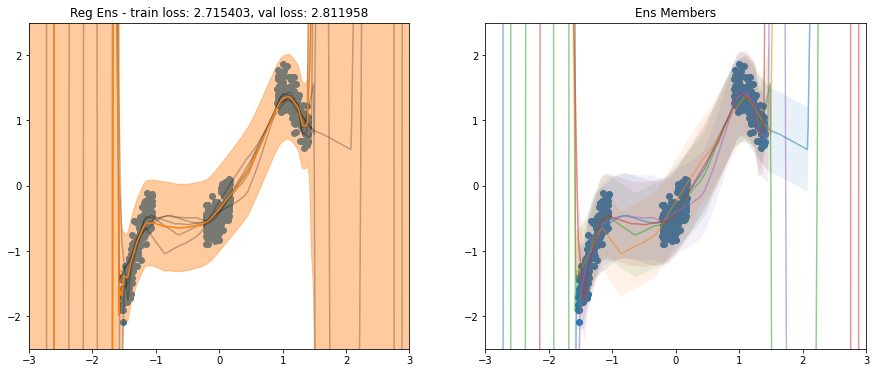

Best val_loss
epoch: 142 - train loss: 2.69326, val_loss: 2.78249, lr: 0.00010
Best val_loss
epoch: 143 - train loss: 2.67112, val_loss: 2.75573, lr: 0.00010
Best val_loss
epoch: 144 - train loss: 2.64919, val_loss: 2.73415, lr: 0.00010
Best val_loss
epoch: 145 - train loss: 2.62738, val_loss: 2.71086, lr: 0.00010
Best val_loss
epoch: 146 - train loss: 2.60560, val_loss: 2.68847, lr: 0.00010
Best val_loss
epoch: 147 - train loss: 2.58400, val_loss: 2.66684, lr: 0.00010
Best val_loss
epoch: 148 - train loss: 2.56235, val_loss: 2.64599, lr: 0.00010
Best val_loss
epoch: 149 - train loss: 2.54059, val_loss: 2.62589, lr: 0.00010
Best val_loss
epoch: 150 - train loss: 2.51895, val_loss: 2.60493, lr: 0.00010
Best val_loss
epoch: 151 - train loss: 2.49747, val_loss: 2.58486, lr: 0.00010
Best val_loss
epoch: 152 - train loss: 2.47594, val_loss: 2.56501, lr: 0.00010
Best val_loss
epoch: 153 - train loss: 2.45451, val_loss: 2.54344, lr: 0.00010
Best val_loss
epoch: 154 - train loss: 2.43306, val_

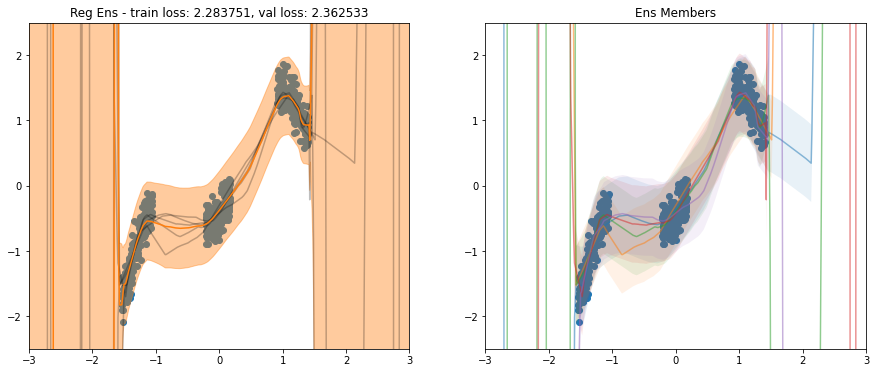

Best val_loss
epoch: 162 - train loss: 2.26242, val_loss: 2.34198, lr: 0.00010
Best val_loss
epoch: 163 - train loss: 2.24144, val_loss: 2.32105, lr: 0.00010
Best val_loss
epoch: 164 - train loss: 2.22030, val_loss: 2.29939, lr: 0.00010
Best val_loss
epoch: 165 - train loss: 2.19931, val_loss: 2.27707, lr: 0.00010
Best val_loss
epoch: 166 - train loss: 2.17824, val_loss: 2.25493, lr: 0.00010
Best val_loss
epoch: 167 - train loss: 2.15741, val_loss: 2.23325, lr: 0.00010
Best val_loss
epoch: 168 - train loss: 2.13643, val_loss: 2.21180, lr: 0.00010
Best val_loss
epoch: 169 - train loss: 2.11554, val_loss: 2.19066, lr: 0.00010
Best val_loss
epoch: 170 - train loss: 2.09466, val_loss: 2.16964, lr: 0.00010
Best val_loss
epoch: 171 - train loss: 2.07382, val_loss: 2.14873, lr: 0.00010
Best val_loss
epoch: 172 - train loss: 2.05298, val_loss: 2.12787, lr: 0.00010
Best val_loss
epoch: 173 - train loss: 2.03221, val_loss: 2.10695, lr: 0.00010
Best val_loss
epoch: 174 - train loss: 2.01154, val_

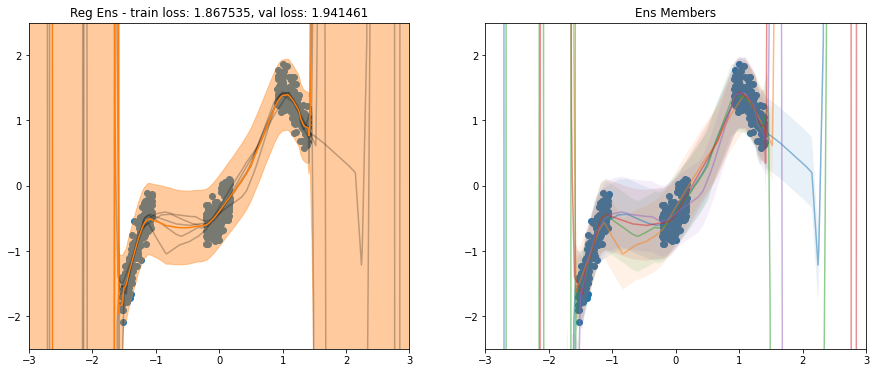

Best val_loss
epoch: 182 - train loss: 1.84714, val_loss: 1.92151, lr: 0.00010
Best val_loss
epoch: 183 - train loss: 1.82684, val_loss: 1.90154, lr: 0.00010
Best val_loss
epoch: 184 - train loss: 1.80649, val_loss: 1.88158, lr: 0.00010
Best val_loss
epoch: 185 - train loss: 1.78623, val_loss: 1.86164, lr: 0.00010
Best val_loss
epoch: 186 - train loss: 1.76606, val_loss: 1.84170, lr: 0.00010
Best val_loss
epoch: 187 - train loss: 1.74585, val_loss: 1.82194, lr: 0.00010
Best val_loss
epoch: 188 - train loss: 1.72564, val_loss: 1.80204, lr: 0.00010
Best val_loss
epoch: 189 - train loss: 1.70567, val_loss: 1.78212, lr: 0.00010
Best val_loss
epoch: 190 - train loss: 1.68562, val_loss: 1.76236, lr: 0.00010
Best val_loss
epoch: 191 - train loss: 1.66561, val_loss: 1.74270, lr: 0.00010
Best val_loss
epoch: 192 - train loss: 1.64556, val_loss: 1.72292, lr: 0.00010
Best val_loss
epoch: 193 - train loss: 1.62550, val_loss: 1.70301, lr: 0.00010
Best val_loss
epoch: 194 - train loss: 1.60549, val_

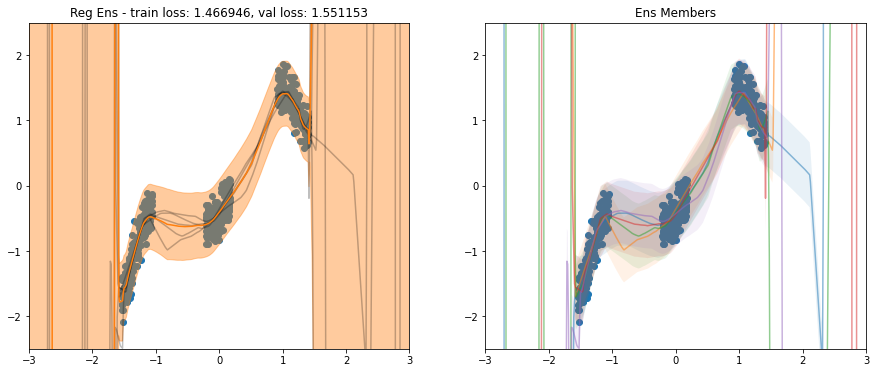

Best val_loss


+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 9.91022, val_loss: 8.01718, lr: 0.00010


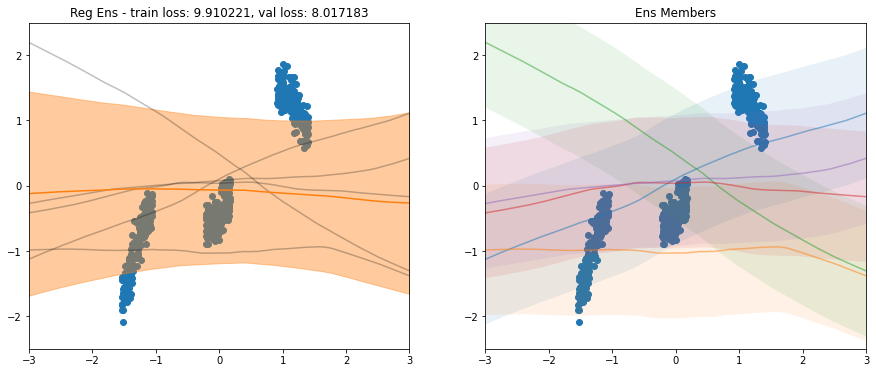

Best val_loss
epoch:   2 - train loss: 9.43830, val_loss: 7.93653, lr: 0.00010
Best val_loss
epoch:   3 - train loss: 9.18338, val_loss: 7.84046, lr: 0.00010
Best val_loss
epoch:   4 - train loss: 8.83571, val_loss: 7.73235, lr: 0.00010
Best val_loss
epoch:   5 - train loss: 8.51796, val_loss: 7.61308, lr: 0.00010
Best val_loss
epoch:   6 - train loss: 8.19780, val_loss: 7.48479, lr: 0.00010
Best val_loss
epoch:   7 - train loss: 7.76934, val_loss: 7.33021, lr: 0.00010
Best val_loss
epoch:   8 - train loss: 7.21305, val_loss: 7.18151, lr: 0.00010
Best val_loss
epoch:   9 - train loss: 6.93172, val_loss: 7.03773, lr: 0.00010
Best val_loss
epoch:  10 - train loss: 6.67058, val_loss: 6.89878, lr: 0.00010
Best val_loss
epoch:  11 - train loss: 6.41502, val_loss: 6.76671, lr: 0.00010
Best val_loss
epoch:  12 - train loss: 6.20155, val_loss: 6.64151, lr: 0.00010
Best val_loss
epoch:  13 - train loss: 6.02095, val_loss: 6.52345, lr: 0.00010
Best val_loss
epoch:  14 - train loss: 5.89503, val_

Best val_loss
epoch:  22 - train loss: 5.27500, val_loss: 5.76254, lr: 0.00010
Best val_loss
epoch:  23 - train loss: 5.23953, val_loss: 5.70826, lr: 0.00010
Best val_loss
epoch:  24 - train loss: 5.20704, val_loss: 5.65843, lr: 0.00010
Best val_loss
epoch:  25 - train loss: 5.17532, val_loss: 5.61233, lr: 0.00010
Best val_loss
epoch:  26 - train loss: 5.14549, val_loss: 5.56999, lr: 0.00010
Best val_loss
epoch:  27 - train loss: 5.11593, val_loss: 5.53090, lr: 0.00010
Best val_loss
epoch:  28 - train loss: 5.08724, val_loss: 5.49440, lr: 0.00010
Best val_loss
epoch:  29 - train loss: 5.05826, val_loss: 5.46003, lr: 0.00010
Best val_loss
epoch:  30 - train loss: 5.02977, val_loss: 5.42735, lr: 0.00010
Best val_loss
epoch:  31 - train loss: 5.00167, val_loss: 5.39590, lr: 0.00010
Best val_loss
epoch:  32 - train loss: 4.97463, val_loss: 5.36503, lr: 0.00010
Best val_loss
epoch:  33 - train loss: 4.94852, val_loss: 5.33423, lr: 0.00010
Best val_loss
epoch:  34 - train loss: 4.92290, val_

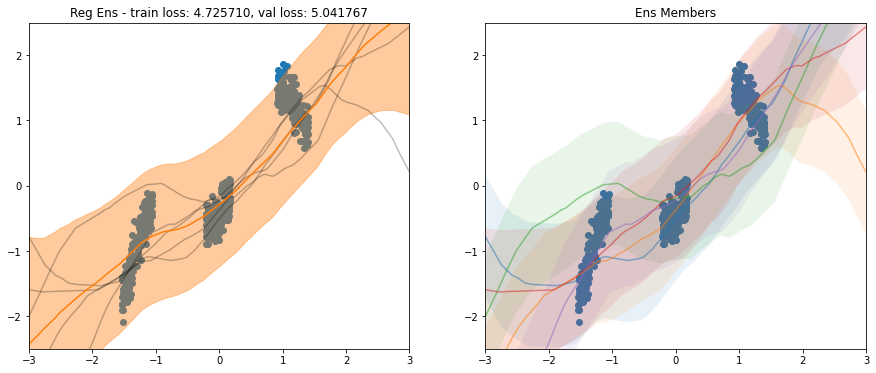

Best val_loss
epoch:  42 - train loss: 4.69765, val_loss: 4.99914, lr: 0.00010
Best val_loss
epoch:  43 - train loss: 4.67123, val_loss: 4.95568, lr: 0.00010
Best val_loss
epoch:  44 - train loss: 4.64465, val_loss: 4.91176, lr: 0.00010
Best val_loss
epoch:  45 - train loss: 4.61655, val_loss: 4.86726, lr: 0.00010
Best val_loss
epoch:  46 - train loss: 4.58691, val_loss: 4.82320, lr: 0.00010
Best val_loss
epoch:  47 - train loss: 4.55694, val_loss: 4.78017, lr: 0.00010
Best val_loss
epoch:  48 - train loss: 4.52885, val_loss: 4.73874, lr: 0.00010
Best val_loss
epoch:  49 - train loss: 4.50247, val_loss: 4.69939, lr: 0.00010
Best val_loss
epoch:  50 - train loss: 4.47677, val_loss: 4.66224, lr: 0.00010
Best val_loss
epoch:  51 - train loss: 4.45159, val_loss: 4.62744, lr: 0.00010
Best val_loss
epoch:  52 - train loss: 4.42644, val_loss: 4.59485, lr: 0.00010
Best val_loss
epoch:  53 - train loss: 4.40108, val_loss: 4.56390, lr: 0.00010
Best val_loss
epoch:  54 - train loss: 4.37668, val_

Best val_loss
epoch:  62 - train loss: 4.17615, val_loss: 4.31421, lr: 0.00010
Best val_loss
epoch:  63 - train loss: 4.15229, val_loss: 4.28481, lr: 0.00010
Best val_loss
epoch:  64 - train loss: 4.12850, val_loss: 4.25486, lr: 0.00010
Best val_loss
epoch:  65 - train loss: 4.10459, val_loss: 4.22452, lr: 0.00010
Best val_loss
epoch:  66 - train loss: 4.08045, val_loss: 4.19408, lr: 0.00010
Best val_loss
epoch:  67 - train loss: 4.05640, val_loss: 4.16368, lr: 0.00010
Best val_loss
epoch:  68 - train loss: 4.03240, val_loss: 4.13350, lr: 0.00010
Best val_loss
epoch:  69 - train loss: 4.00849, val_loss: 4.10311, lr: 0.00010
Best val_loss
epoch:  70 - train loss: 3.98451, val_loss: 4.07296, lr: 0.00010
Best val_loss
epoch:  71 - train loss: 3.96076, val_loss: 4.04299, lr: 0.00010
Best val_loss
epoch:  72 - train loss: 3.93712, val_loss: 4.01388, lr: 0.00010
Best val_loss
epoch:  73 - train loss: 3.91356, val_loss: 3.98539, lr: 0.00010
Best val_loss
epoch:  74 - train loss: 3.89022, val_

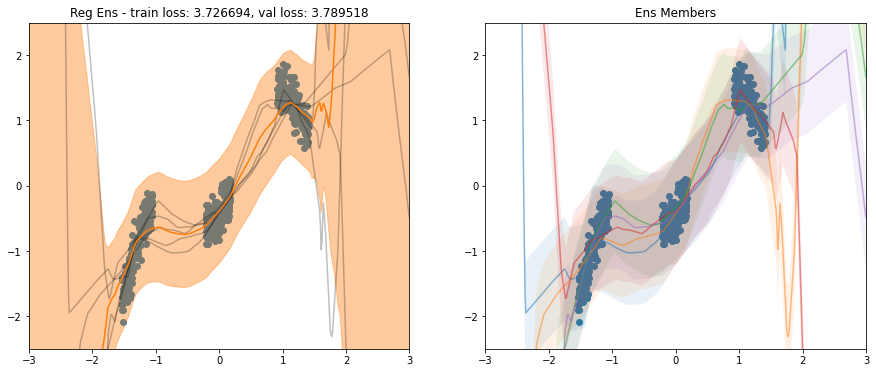

Best val_loss
epoch:  82 - train loss: 3.70361, val_loss: 3.76719, lr: 0.00010
Best val_loss
epoch:  83 - train loss: 3.68060, val_loss: 3.74487, lr: 0.00010
Best val_loss
epoch:  84 - train loss: 3.65765, val_loss: 3.72250, lr: 0.00010
Best val_loss
epoch:  85 - train loss: 3.63471, val_loss: 3.70007, lr: 0.00010
Best val_loss
epoch:  86 - train loss: 3.61177, val_loss: 3.67752, lr: 0.00010
Best val_loss
epoch:  87 - train loss: 3.58891, val_loss: 3.65486, lr: 0.00010
Best val_loss
epoch:  88 - train loss: 3.56609, val_loss: 3.63210, lr: 0.00010
Best val_loss
epoch:  89 - train loss: 3.54334, val_loss: 3.60941, lr: 0.00010
Best val_loss
epoch:  90 - train loss: 3.52059, val_loss: 3.58684, lr: 0.00010
Best val_loss
epoch:  91 - train loss: 3.49793, val_loss: 3.56442, lr: 0.00010
Best val_loss
epoch:  92 - train loss: 3.47530, val_loss: 3.54227, lr: 0.00010
Best val_loss
epoch:  93 - train loss: 3.45273, val_loss: 3.52056, lr: 0.00010
Best val_loss
epoch:  94 - train loss: 3.43019, val_

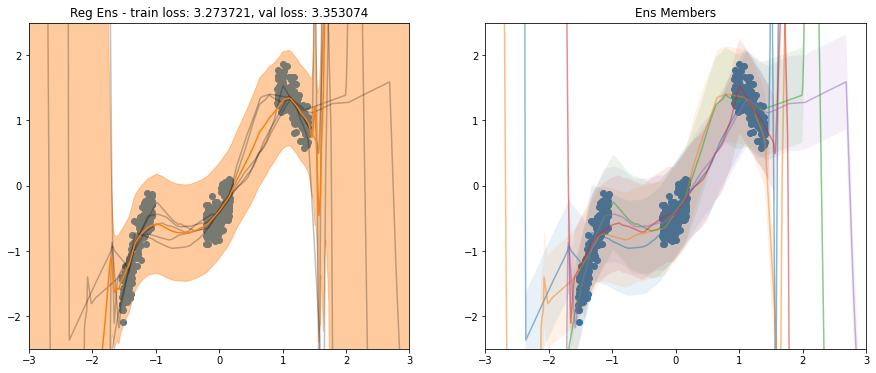

Best val_loss
epoch: 102 - train loss: 3.25149, val_loss: 3.33177, lr: 0.00010
Best val_loss
epoch: 103 - train loss: 3.22931, val_loss: 3.31016, lr: 0.00010
Best val_loss
epoch: 104 - train loss: 3.20714, val_loss: 3.28840, lr: 0.00010
Best val_loss
epoch: 105 - train loss: 3.18496, val_loss: 3.26649, lr: 0.00010
Best val_loss
epoch: 106 - train loss: 3.16282, val_loss: 3.24448, lr: 0.00010
Best val_loss
epoch: 107 - train loss: 3.14066, val_loss: 3.22239, lr: 0.00010
Best val_loss
epoch: 108 - train loss: 3.11855, val_loss: 3.20038, lr: 0.00010
Best val_loss
epoch: 109 - train loss: 3.09646, val_loss: 3.17828, lr: 0.00010
Best val_loss
epoch: 110 - train loss: 3.07438, val_loss: 3.15620, lr: 0.00010
Best val_loss
epoch: 111 - train loss: 3.05234, val_loss: 3.13428, lr: 0.00010
Best val_loss
epoch: 112 - train loss: 3.03032, val_loss: 3.11258, lr: 0.00010
Best val_loss
epoch: 113 - train loss: 3.00828, val_loss: 3.09105, lr: 0.00010
Best val_loss
epoch: 114 - train loss: 2.98641, val_

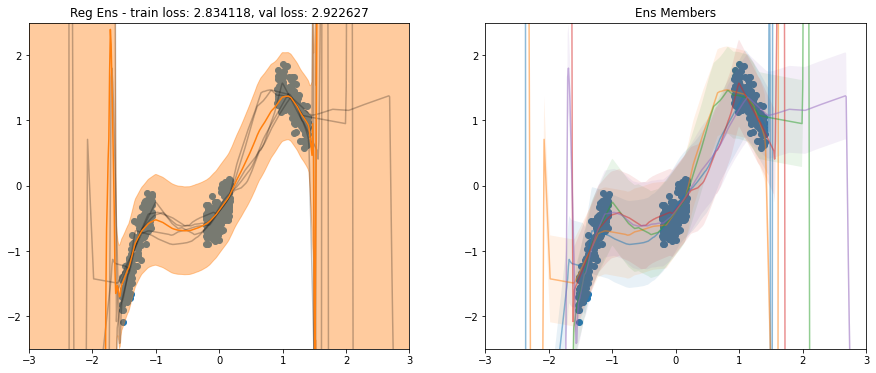

Best val_loss
epoch: 122 - train loss: 2.81233, val_loss: 2.90172, lr: 0.00010
Best val_loss
epoch: 123 - train loss: 2.79068, val_loss: 2.88104, lr: 0.00010
Best val_loss
epoch: 124 - train loss: 2.76906, val_loss: 2.86041, lr: 0.00010
Best val_loss
epoch: 125 - train loss: 2.74747, val_loss: 2.83983, lr: 0.00010
Best val_loss
epoch: 126 - train loss: 2.72593, val_loss: 2.81922, lr: 0.00010
Best val_loss
epoch: 127 - train loss: 2.70443, val_loss: 2.79850, lr: 0.00010
Best val_loss
epoch: 128 - train loss: 2.68300, val_loss: 2.77773, lr: 0.00010
Best val_loss
epoch: 129 - train loss: 2.66163, val_loss: 2.75670, lr: 0.00010
Best val_loss
epoch: 130 - train loss: 2.64024, val_loss: 2.73545, lr: 0.00010
Best val_loss
epoch: 131 - train loss: 2.61874, val_loss: 2.71405, lr: 0.00010
Best val_loss
epoch: 132 - train loss: 2.59731, val_loss: 2.69257, lr: 0.00010
Best val_loss
epoch: 133 - train loss: 2.57598, val_loss: 2.67086, lr: 0.00010
Best val_loss
epoch: 134 - train loss: 2.55464, val_

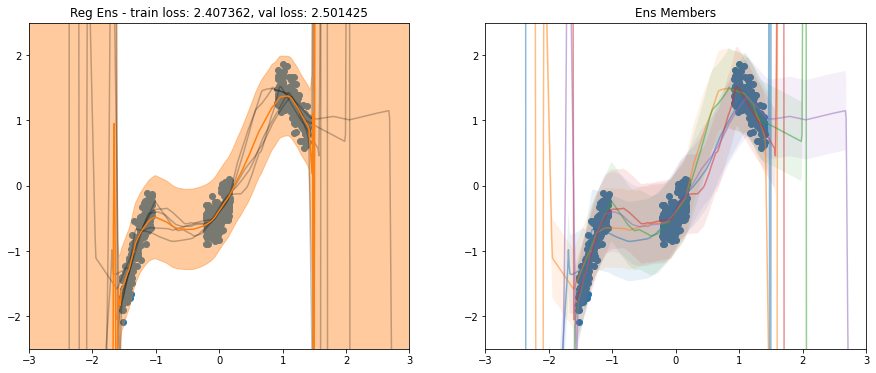

Best val_loss
epoch: 142 - train loss: 2.38647, val_loss: 2.48111, lr: 0.00010
Best val_loss
epoch: 143 - train loss: 2.36575, val_loss: 2.46102, lr: 0.00010
Best val_loss
epoch: 144 - train loss: 2.34491, val_loss: 2.44115, lr: 0.00010
Best val_loss
epoch: 145 - train loss: 2.32411, val_loss: 2.42152, lr: 0.00010
Best val_loss
epoch: 146 - train loss: 2.30325, val_loss: 2.40196, lr: 0.00010
Best val_loss
epoch: 147 - train loss: 2.28253, val_loss: 2.38236, lr: 0.00010
Best val_loss
epoch: 148 - train loss: 2.26184, val_loss: 2.36270, lr: 0.00010
Best val_loss
epoch: 149 - train loss: 2.24118, val_loss: 2.34304, lr: 0.00010
Best val_loss
epoch: 150 - train loss: 2.22048, val_loss: 2.32344, lr: 0.00010
Best val_loss
epoch: 151 - train loss: 2.19977, val_loss: 2.30397, lr: 0.00010
Best val_loss
epoch: 152 - train loss: 2.17921, val_loss: 2.28440, lr: 0.00010
Best val_loss
epoch: 153 - train loss: 2.15859, val_loss: 2.26478, lr: 0.00010
Best val_loss
epoch: 154 - train loss: 2.13810, val_

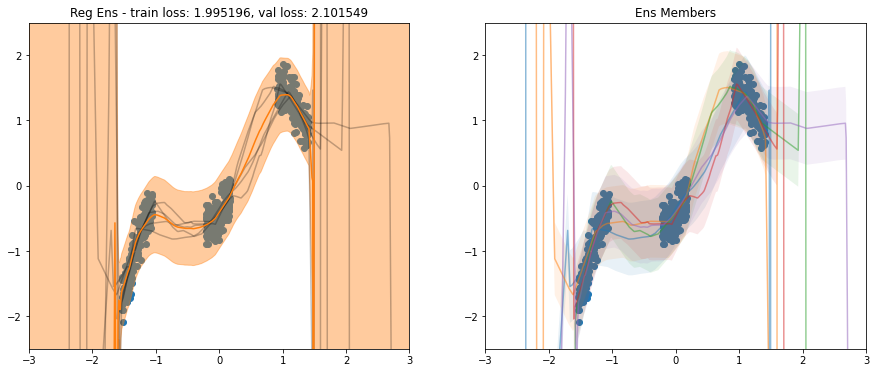

Best val_loss
epoch: 162 - train loss: 1.97507, val_loss: 2.08134, lr: 0.00010
Best val_loss
epoch: 163 - train loss: 1.95496, val_loss: 2.06143, lr: 0.00010
Best val_loss
epoch: 164 - train loss: 1.93480, val_loss: 2.04175, lr: 0.00010
Best val_loss
epoch: 165 - train loss: 1.91470, val_loss: 2.02236, lr: 0.00010
Best val_loss
epoch: 166 - train loss: 1.89464, val_loss: 2.00319, lr: 0.00010
Best val_loss
epoch: 167 - train loss: 1.87469, val_loss: 1.98393, lr: 0.00010
Best val_loss
epoch: 168 - train loss: 1.85471, val_loss: 1.96436, lr: 0.00010
Best val_loss
epoch: 169 - train loss: 1.83490, val_loss: 1.94476, lr: 0.00010
Best val_loss
epoch: 170 - train loss: 1.81512, val_loss: 1.92502, lr: 0.00010
Best val_loss
epoch: 171 - train loss: 1.79537, val_loss: 1.90504, lr: 0.00010
Best val_loss
epoch: 172 - train loss: 1.77560, val_loss: 1.88478, lr: 0.00010
Best val_loss
epoch: 173 - train loss: 1.75582, val_loss: 1.86420, lr: 0.00010
Best val_loss
epoch: 174 - train loss: 1.73621, val_

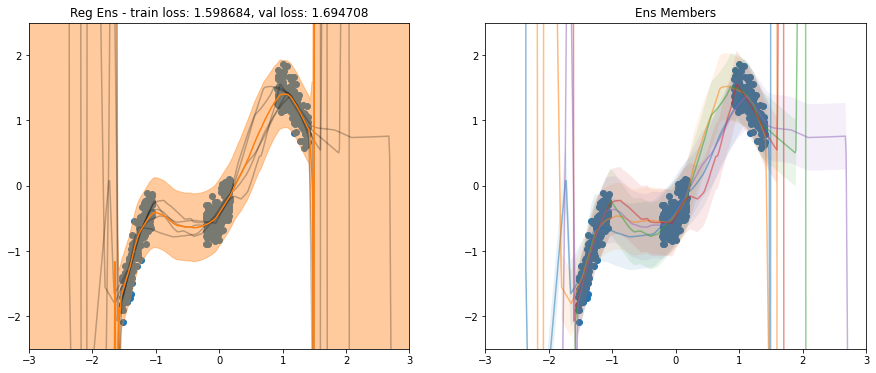

Best val_loss
epoch: 182 - train loss: 1.57921, val_loss: 1.67416, lr: 0.00010
Best val_loss
epoch: 183 - train loss: 1.55976, val_loss: 1.65401, lr: 0.00010
Best val_loss
epoch: 184 - train loss: 1.54030, val_loss: 1.63427, lr: 0.00010
Best val_loss
epoch: 185 - train loss: 1.52095, val_loss: 1.61505, lr: 0.00010
Best val_loss
epoch: 186 - train loss: 1.50156, val_loss: 1.59612, lr: 0.00010
Best val_loss
epoch: 187 - train loss: 1.48224, val_loss: 1.57761, lr: 0.00010
Best val_loss
epoch: 188 - train loss: 1.46295, val_loss: 1.55949, lr: 0.00010
Best val_loss
epoch: 189 - train loss: 1.44361, val_loss: 1.54155, lr: 0.00010
Best val_loss
epoch: 190 - train loss: 1.42422, val_loss: 1.52353, lr: 0.00010
Best val_loss
epoch: 191 - train loss: 1.40501, val_loss: 1.50470, lr: 0.00010
Best val_loss
epoch: 192 - train loss: 1.38591, val_loss: 1.48603, lr: 0.00010
Best val_loss
epoch: 193 - train loss: 1.36687, val_loss: 1.46781, lr: 0.00010
Best val_loss
epoch: 194 - train loss: 1.34782, val_

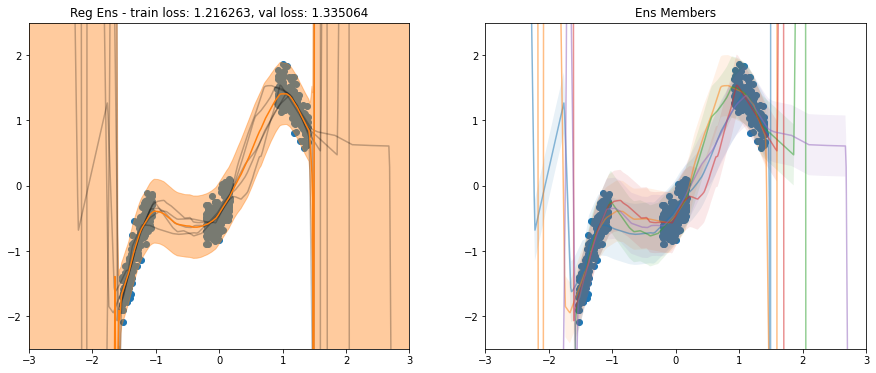

Best val_loss


In [7]:
config = get_reg_ens_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_ens_states = []
for i in range(3):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    ens_model, state = setup_training(config, setup_rng, init_x, init_y)

    if RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            ens_model, state, config, rng, make_Reg_Ens_loss, make_Reg_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_Reg_Ens_plots,
        )

        best_ens_states.append(best_state)

In [8]:
if RETRAIN:  # RETRAIN
    save_checkpoint('ens_models', best_ens_states, 1, overwrite=True)

## PoN

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 9.37653, val_loss: 8.40483, lr: 0.00010


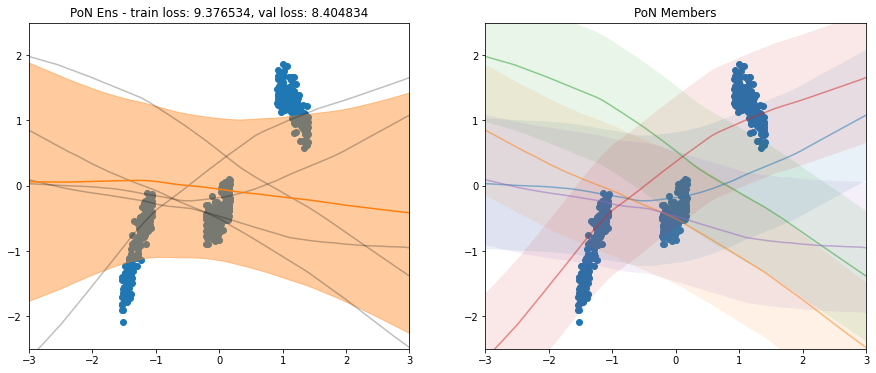

Best val_loss
epoch:   2 - train loss: 9.07656, val_loss: 8.41471, lr: 0.00010
epoch:   3 - train loss: 8.79701, val_loss: 8.40264, lr: 0.00010
Best val_loss
epoch:   4 - train loss: 8.54451, val_loss: 8.37102, lr: 0.00010
Best val_loss
epoch:   5 - train loss: 8.26969, val_loss: 8.32107, lr: 0.00010
Best val_loss
epoch:   6 - train loss: 7.97982, val_loss: 8.25451, lr: 0.00010
Best val_loss
epoch:   7 - train loss: 7.68742, val_loss: 8.16831, lr: 0.00010
Best val_loss
epoch:   8 - train loss: 7.41255, val_loss: 8.07020, lr: 0.00010
Best val_loss
epoch:   9 - train loss: 7.16131, val_loss: 7.96319, lr: 0.00010
Best val_loss
epoch:  10 - train loss: 6.93225, val_loss: 7.84935, lr: 0.00010
Best val_loss
epoch:  11 - train loss: 6.72908, val_loss: 7.73126, lr: 0.00010
Best val_loss
epoch:  12 - train loss: 6.55298, val_loss: 7.61064, lr: 0.00010
Best val_loss
epoch:  13 - train loss: 6.39774, val_loss: 7.48967, lr: 0.00010
Best val_loss
epoch:  14 - train loss: 6.27311, val_loss: 7.36955,

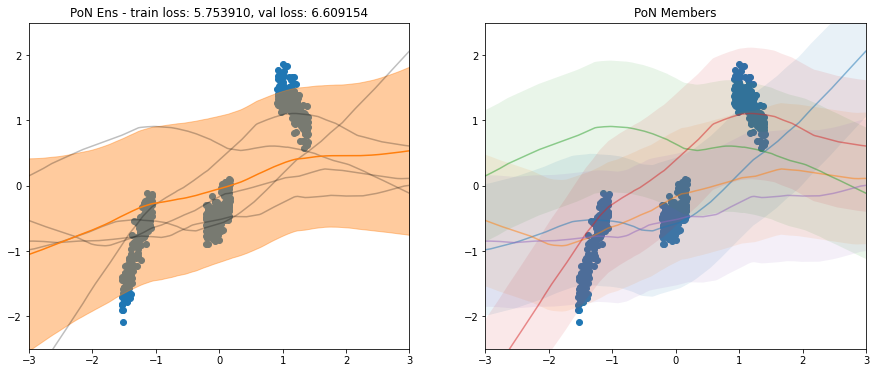

Best val_loss
epoch:  22 - train loss: 5.71226, val_loss: 6.51877, lr: 0.00010
Best val_loss
epoch:  23 - train loss: 5.67303, val_loss: 6.43374, lr: 0.00010
Best val_loss
epoch:  24 - train loss: 5.63590, val_loss: 6.35347, lr: 0.00010
Best val_loss
epoch:  25 - train loss: 5.59951, val_loss: 6.27758, lr: 0.00010
Best val_loss
epoch:  26 - train loss: 5.56341, val_loss: 6.20542, lr: 0.00010
Best val_loss
epoch:  27 - train loss: 5.52694, val_loss: 6.13683, lr: 0.00010
Best val_loss
epoch:  28 - train loss: 5.48996, val_loss: 6.07186, lr: 0.00010
Best val_loss
epoch:  29 - train loss: 5.45231, val_loss: 6.01016, lr: 0.00010
Best val_loss
epoch:  30 - train loss: 5.41391, val_loss: 5.95141, lr: 0.00010
Best val_loss
epoch:  31 - train loss: 5.37520, val_loss: 5.89578, lr: 0.00010
Best val_loss
epoch:  32 - train loss: 5.33607, val_loss: 5.84288, lr: 0.00010
Best val_loss
epoch:  33 - train loss: 5.29692, val_loss: 5.79241, lr: 0.00010
Best val_loss
epoch:  34 - train loss: 5.25773, val_

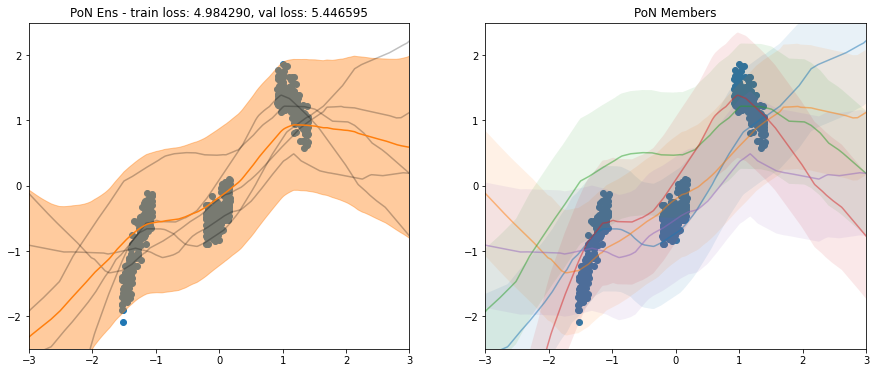

Best val_loss
epoch:  42 - train loss: 4.94762, val_loss: 5.40734, lr: 0.00010
Best val_loss
epoch:  43 - train loss: 4.91120, val_loss: 5.36802, lr: 0.00010
Best val_loss
epoch:  44 - train loss: 4.87599, val_loss: 5.32854, lr: 0.00010
Best val_loss
epoch:  45 - train loss: 4.84141, val_loss: 5.28888, lr: 0.00010
Best val_loss
epoch:  46 - train loss: 4.80728, val_loss: 5.24903, lr: 0.00010
Best val_loss
epoch:  47 - train loss: 4.77394, val_loss: 5.20948, lr: 0.00010
Best val_loss
epoch:  48 - train loss: 4.74109, val_loss: 5.16947, lr: 0.00010
Best val_loss
epoch:  49 - train loss: 4.70881, val_loss: 5.12844, lr: 0.00010
Best val_loss
epoch:  50 - train loss: 4.67698, val_loss: 5.08652, lr: 0.00010
Best val_loss
epoch:  51 - train loss: 4.64553, val_loss: 5.04385, lr: 0.00010
Best val_loss
epoch:  52 - train loss: 4.61453, val_loss: 5.00125, lr: 0.00010
Best val_loss
epoch:  53 - train loss: 4.58401, val_loss: 4.95939, lr: 0.00010
Best val_loss
epoch:  54 - train loss: 4.55379, val_

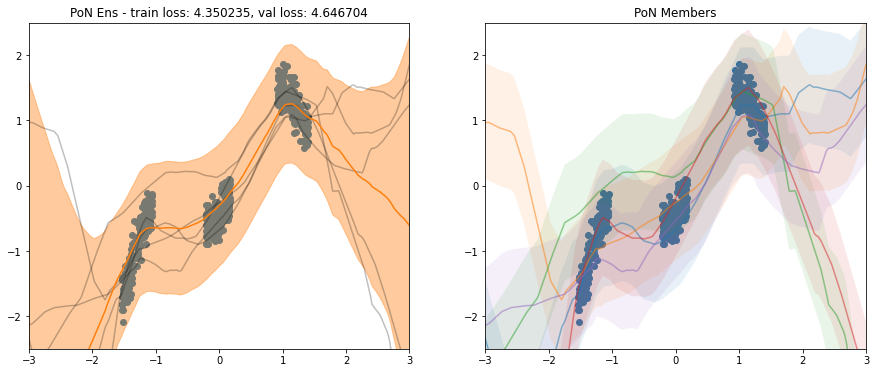

Best val_loss
epoch:  62 - train loss: 4.32201, val_loss: 4.60907, lr: 0.00010
Best val_loss
epoch:  63 - train loss: 4.29400, val_loss: 4.57174, lr: 0.00010
Best val_loss
epoch:  64 - train loss: 4.26620, val_loss: 4.53462, lr: 0.00010
Best val_loss
epoch:  65 - train loss: 4.23872, val_loss: 4.49771, lr: 0.00010
Best val_loss
epoch:  66 - train loss: 4.21131, val_loss: 4.46096, lr: 0.00010
Best val_loss
epoch:  67 - train loss: 4.18413, val_loss: 4.42418, lr: 0.00010
Best val_loss
epoch:  68 - train loss: 4.15724, val_loss: 4.38712, lr: 0.00010
Best val_loss
epoch:  69 - train loss: 4.13049, val_loss: 4.35005, lr: 0.00010
Best val_loss
epoch:  70 - train loss: 4.10382, val_loss: 4.31351, lr: 0.00010
Best val_loss
epoch:  71 - train loss: 4.07729, val_loss: 4.27770, lr: 0.00010
Best val_loss
epoch:  72 - train loss: 4.05086, val_loss: 4.24235, lr: 0.00010
Best val_loss
epoch:  73 - train loss: 4.02463, val_loss: 4.20725, lr: 0.00010
Best val_loss
epoch:  74 - train loss: 3.99866, val_

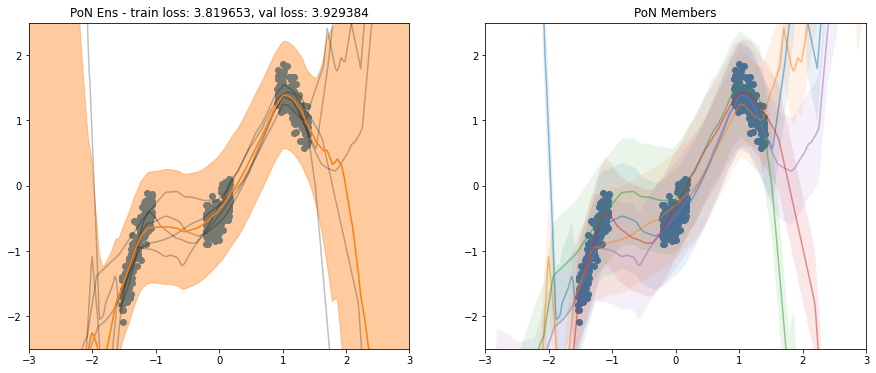

Best val_loss
epoch:  82 - train loss: 3.79442, val_loss: 3.89760, lr: 0.00010
Best val_loss
epoch:  83 - train loss: 3.76916, val_loss: 3.86691, lr: 0.00010
Best val_loss
epoch:  84 - train loss: 3.74408, val_loss: 3.83732, lr: 0.00010
Best val_loss
epoch:  85 - train loss: 3.71891, val_loss: 3.80867, lr: 0.00010
Best val_loss
epoch:  86 - train loss: 3.69375, val_loss: 3.78060, lr: 0.00010
Best val_loss
epoch:  87 - train loss: 3.66853, val_loss: 3.75308, lr: 0.00010
Best val_loss
epoch:  88 - train loss: 3.64321, val_loss: 3.72602, lr: 0.00010
Best val_loss
epoch:  89 - train loss: 3.61768, val_loss: 3.69941, lr: 0.00010
Best val_loss
epoch:  90 - train loss: 3.59198, val_loss: 3.67351, lr: 0.00010
Best val_loss
epoch:  91 - train loss: 3.56625, val_loss: 3.64809, lr: 0.00010
Best val_loss
epoch:  92 - train loss: 3.54037, val_loss: 3.62340, lr: 0.00010
Best val_loss
epoch:  93 - train loss: 3.51545, val_loss: 3.59932, lr: 0.00010
Best val_loss
epoch:  94 - train loss: 3.49219, val_

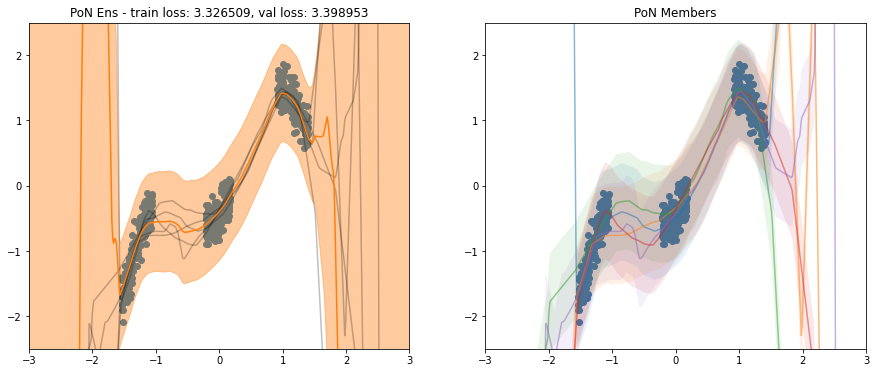

Best val_loss
epoch: 102 - train loss: 3.30396, val_loss: 3.37524, lr: 0.00010
Best val_loss
epoch: 103 - train loss: 3.28093, val_loss: 3.35178, lr: 0.00010
Best val_loss
epoch: 104 - train loss: 3.25750, val_loss: 3.32849, lr: 0.00010
Best val_loss
epoch: 105 - train loss: 3.23345, val_loss: 3.30535, lr: 0.00010
Best val_loss
epoch: 106 - train loss: 3.20957, val_loss: 3.28236, lr: 0.00010
Best val_loss
epoch: 107 - train loss: 3.18652, val_loss: 3.25957, lr: 0.00010
Best val_loss
epoch: 108 - train loss: 3.16428, val_loss: 3.23621, lr: 0.00010
Best val_loss
epoch: 109 - train loss: 3.14176, val_loss: 3.21259, lr: 0.00010
Best val_loss
epoch: 110 - train loss: 3.11877, val_loss: 3.18964, lr: 0.00010
Best val_loss
epoch: 111 - train loss: 3.09522, val_loss: 3.16733, lr: 0.00010
Best val_loss
epoch: 112 - train loss: 3.07197, val_loss: 3.14567, lr: 0.00010
Best val_loss
epoch: 113 - train loss: 3.04942, val_loss: 3.12399, lr: 0.00010
Best val_loss
epoch: 114 - train loss: 3.02711, val_

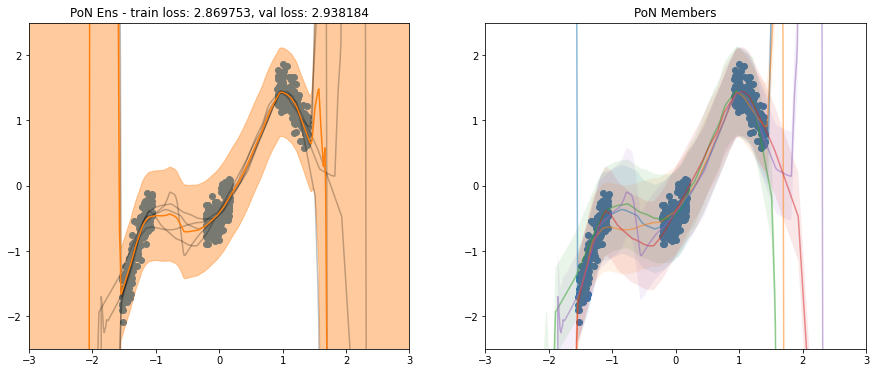

Best val_loss
epoch: 122 - train loss: 2.84718, val_loss: 2.91618, lr: 0.00010
Best val_loss
epoch: 123 - train loss: 2.82501, val_loss: 2.89430, lr: 0.00010
Best val_loss
epoch: 124 - train loss: 2.80296, val_loss: 2.87232, lr: 0.00010
Best val_loss
epoch: 125 - train loss: 2.78108, val_loss: 2.84947, lr: 0.00010
Best val_loss
epoch: 126 - train loss: 2.75919, val_loss: 2.82520, lr: 0.00010
Best val_loss
epoch: 127 - train loss: 2.73709, val_loss: 2.80053, lr: 0.00010
Best val_loss
epoch: 128 - train loss: 2.71516, val_loss: 2.77597, lr: 0.00010
Best val_loss
epoch: 129 - train loss: 2.69336, val_loss: 2.75185, lr: 0.00010
Best val_loss
epoch: 130 - train loss: 2.67167, val_loss: 2.72816, lr: 0.00010
Best val_loss
epoch: 131 - train loss: 2.65004, val_loss: 2.70498, lr: 0.00010
Best val_loss
epoch: 132 - train loss: 2.62829, val_loss: 2.68225, lr: 0.00010
Best val_loss
epoch: 133 - train loss: 2.60668, val_loss: 2.65957, lr: 0.00010
Best val_loss
epoch: 134 - train loss: 2.58522, val_

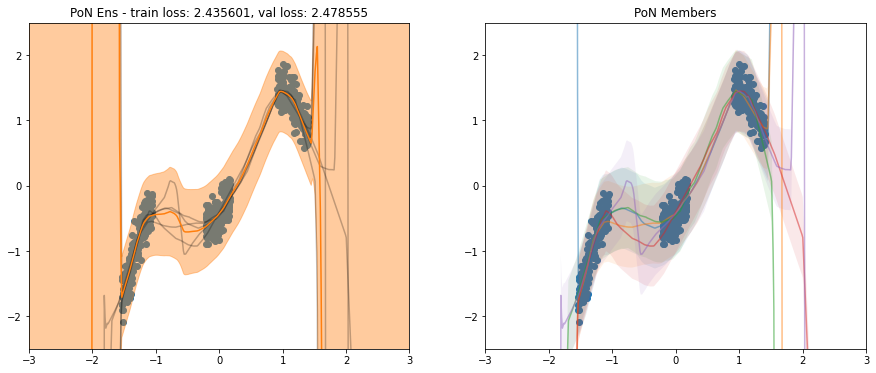

Best val_loss
epoch: 142 - train loss: 2.41423, val_loss: 2.45712, lr: 0.00010
Best val_loss
epoch: 143 - train loss: 2.39303, val_loss: 2.43582, lr: 0.00010
Best val_loss
epoch: 144 - train loss: 2.37190, val_loss: 2.41454, lr: 0.00010
Best val_loss
epoch: 145 - train loss: 2.35075, val_loss: 2.39366, lr: 0.00010
Best val_loss
epoch: 146 - train loss: 2.32954, val_loss: 2.37275, lr: 0.00010
Best val_loss
epoch: 147 - train loss: 2.30829, val_loss: 2.35172, lr: 0.00010
Best val_loss
epoch: 148 - train loss: 2.28728, val_loss: 2.33051, lr: 0.00010
Best val_loss
epoch: 149 - train loss: 2.26625, val_loss: 2.30941, lr: 0.00010
Best val_loss
epoch: 150 - train loss: 2.24531, val_loss: 2.28894, lr: 0.00010
Best val_loss
epoch: 151 - train loss: 2.22421, val_loss: 2.26902, lr: 0.00010
Best val_loss
epoch: 152 - train loss: 2.20331, val_loss: 2.24906, lr: 0.00010
Best val_loss
epoch: 153 - train loss: 2.18248, val_loss: 2.22875, lr: 0.00010
Best val_loss
epoch: 154 - train loss: 2.16156, val_

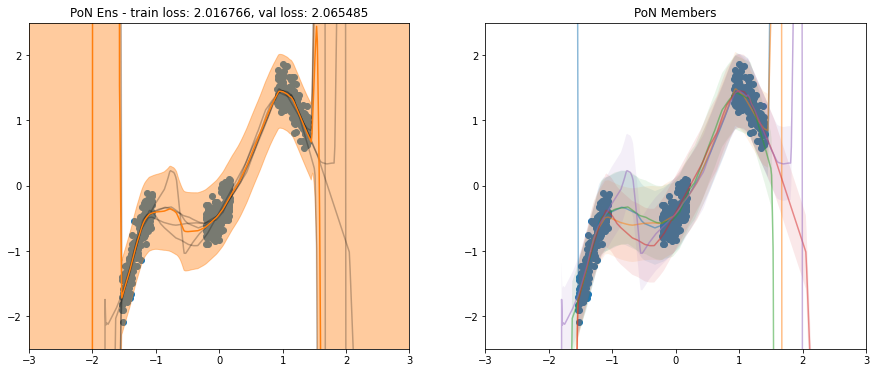

Best val_loss
epoch: 162 - train loss: 1.99640, val_loss: 2.04541, lr: 0.00010
Best val_loss
epoch: 163 - train loss: 1.97598, val_loss: 2.02572, lr: 0.00010
Best val_loss
epoch: 164 - train loss: 1.95550, val_loss: 2.00625, lr: 0.00010
Best val_loss
epoch: 165 - train loss: 1.93499, val_loss: 1.98650, lr: 0.00010
Best val_loss
epoch: 166 - train loss: 1.91454, val_loss: 1.96611, lr: 0.00010
Best val_loss
epoch: 167 - train loss: 1.89409, val_loss: 1.94599, lr: 0.00010
Best val_loss
epoch: 168 - train loss: 1.87381, val_loss: 1.92710, lr: 0.00010
Best val_loss
epoch: 169 - train loss: 1.85352, val_loss: 1.90861, lr: 0.00010
Best val_loss
epoch: 170 - train loss: 1.83335, val_loss: 1.88946, lr: 0.00010
Best val_loss
epoch: 171 - train loss: 1.81323, val_loss: 1.86897, lr: 0.00010
Best val_loss
epoch: 172 - train loss: 1.79290, val_loss: 1.84891, lr: 0.00010
Best val_loss
epoch: 173 - train loss: 1.77283, val_loss: 1.82967, lr: 0.00010
Best val_loss
epoch: 174 - train loss: 1.75276, val_

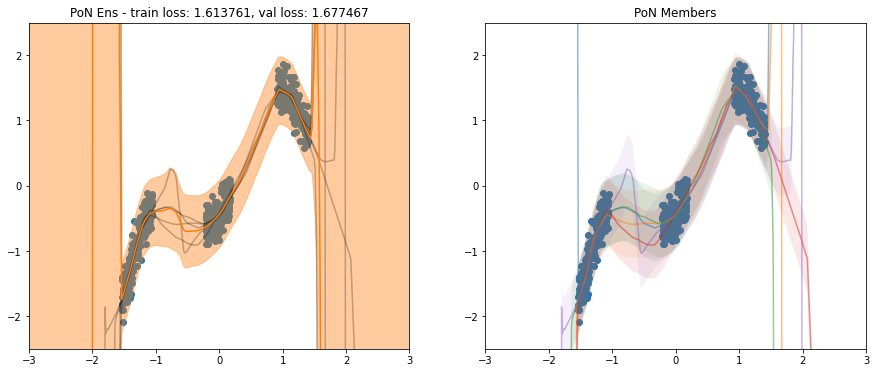

Best val_loss
epoch: 182 - train loss: 1.59406, val_loss: 1.65871, lr: 0.00010
Best val_loss
epoch: 183 - train loss: 1.57435, val_loss: 1.63924, lr: 0.00010
Best val_loss
epoch: 184 - train loss: 1.55461, val_loss: 1.61946, lr: 0.00010
Best val_loss
epoch: 185 - train loss: 1.53495, val_loss: 1.60009, lr: 0.00010
Best val_loss
epoch: 186 - train loss: 1.51548, val_loss: 1.58113, lr: 0.00010
Best val_loss
epoch: 187 - train loss: 1.49601, val_loss: 1.56237, lr: 0.00010
Best val_loss
epoch: 188 - train loss: 1.47661, val_loss: 1.54384, lr: 0.00010
Best val_loss
epoch: 189 - train loss: 1.45723, val_loss: 1.52535, lr: 0.00010
Best val_loss
epoch: 190 - train loss: 1.43786, val_loss: 1.50707, lr: 0.00010
Best val_loss
epoch: 191 - train loss: 1.41858, val_loss: 1.48873, lr: 0.00010
Best val_loss
epoch: 192 - train loss: 1.39941, val_loss: 1.47013, lr: 0.00010
Best val_loss
epoch: 193 - train loss: 1.38012, val_loss: 1.45125, lr: 0.00010
Best val_loss
epoch: 194 - train loss: 1.36102, val_

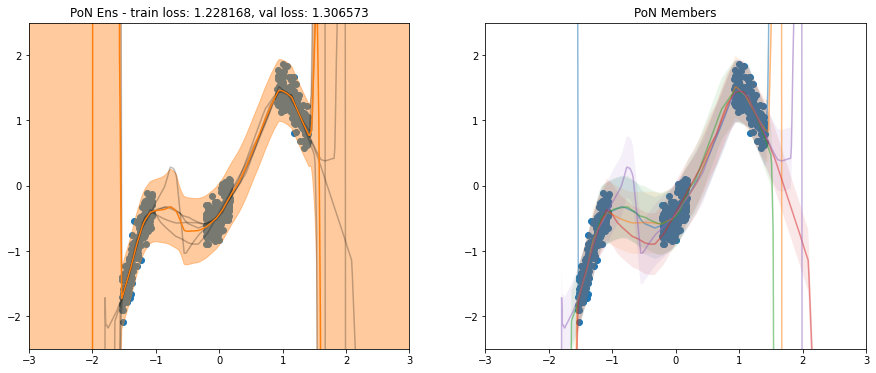

Best val_loss


+---------------------------------------------+----------+-------+----------+--------+
| Name                                        | Shape    | Size  | Mean     | Std    |
+---------------------------------------------+----------+-------+----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_2/layer_0/BatchNorm_0/me

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 9.22971, val_loss: 7.38362, lr: 0.00010


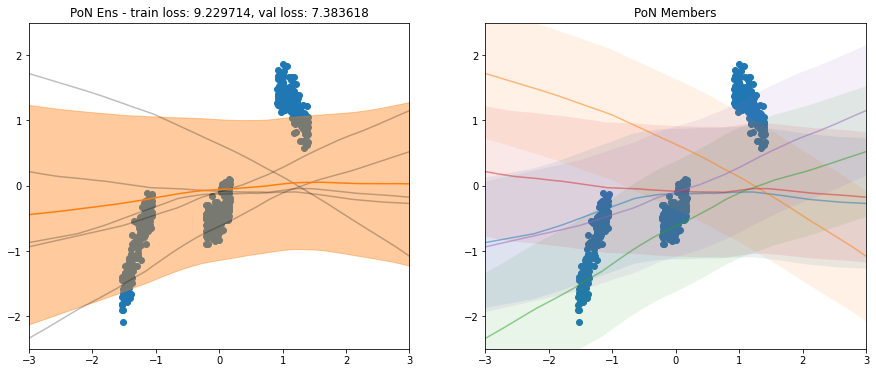

Best val_loss
epoch:   2 - train loss: 9.06075, val_loss: 7.42002, lr: 0.00010
epoch:   3 - train loss: 8.97475, val_loss: 7.44261, lr: 0.00010
epoch:   4 - train loss: 8.86969, val_loss: 7.45007, lr: 0.00010
epoch:   5 - train loss: 8.40386, val_loss: 7.44538, lr: 0.00010
epoch:   6 - train loss: 8.21028, val_loss: 7.42958, lr: 0.00010
epoch:   7 - train loss: 8.00734, val_loss: 7.40402, lr: 0.00010
epoch:   8 - train loss: 7.78386, val_loss: 7.37025, lr: 0.00010
Best val_loss
epoch:   9 - train loss: 7.57154, val_loss: 7.33011, lr: 0.00010
Best val_loss
epoch:  10 - train loss: 7.38495, val_loss: 7.28575, lr: 0.00010
Best val_loss
epoch:  11 - train loss: 7.20874, val_loss: 7.23787, lr: 0.00010
Best val_loss
epoch:  12 - train loss: 7.04218, val_loss: 7.18718, lr: 0.00010
Best val_loss
epoch:  13 - train loss: 6.88811, val_loss: 7.13452, lr: 0.00010
Best val_loss
epoch:  14 - train loss: 6.74764, val_loss: 7.08030, lr: 0.00010
Best val_loss
epoch:  15 - train loss: 6.62065, val_loss:

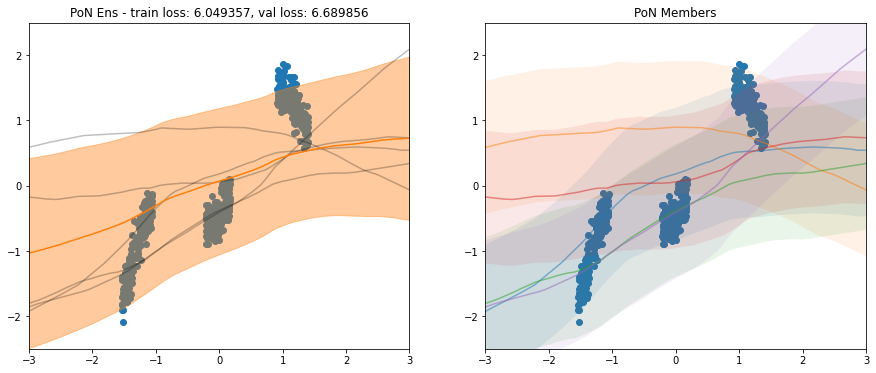

Best val_loss
epoch:  22 - train loss: 6.00391, val_loss: 6.63804, lr: 0.00010
Best val_loss
epoch:  23 - train loss: 5.96108, val_loss: 6.58849, lr: 0.00010
Best val_loss
epoch:  24 - train loss: 5.91953, val_loss: 6.54098, lr: 0.00010
Best val_loss
epoch:  25 - train loss: 5.87823, val_loss: 6.49575, lr: 0.00010
Best val_loss
epoch:  26 - train loss: 5.83505, val_loss: 6.45321, lr: 0.00010
Best val_loss
epoch:  27 - train loss: 5.78132, val_loss: 6.41337, lr: 0.00010
Best val_loss
epoch:  28 - train loss: 5.74013, val_loss: 6.37548, lr: 0.00010
Best val_loss
epoch:  29 - train loss: 5.69902, val_loss: 6.33962, lr: 0.00010
Best val_loss
epoch:  30 - train loss: 5.65593, val_loss: 6.30604, lr: 0.00010
Best val_loss
epoch:  31 - train loss: 5.61068, val_loss: 6.27440, lr: 0.00010
Best val_loss
epoch:  32 - train loss: 5.57290, val_loss: 6.24351, lr: 0.00010
Best val_loss
epoch:  33 - train loss: 5.53955, val_loss: 6.21195, lr: 0.00010
Best val_loss
epoch:  34 - train loss: 5.50927, val_

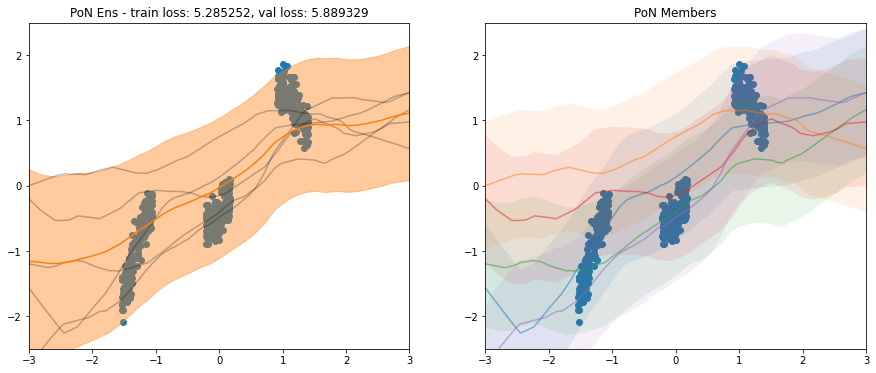

Best val_loss
epoch:  42 - train loss: 5.25235, val_loss: 5.84505, lr: 0.00010
Best val_loss
epoch:  43 - train loss: 5.21948, val_loss: 5.79966, lr: 0.00010
Best val_loss
epoch:  44 - train loss: 5.18674, val_loss: 5.75288, lr: 0.00010
Best val_loss
epoch:  45 - train loss: 5.15352, val_loss: 5.70483, lr: 0.00010
Best val_loss
epoch:  46 - train loss: 5.12071, val_loss: 5.65604, lr: 0.00010
Best val_loss
epoch:  47 - train loss: 5.09245, val_loss: 5.60518, lr: 0.00010
Best val_loss
epoch:  48 - train loss: 5.05821, val_loss: 5.55601, lr: 0.00010
Best val_loss
epoch:  49 - train loss: 5.02780, val_loss: 5.51039, lr: 0.00010
Best val_loss
epoch:  50 - train loss: 4.99551, val_loss: 5.46809, lr: 0.00010
Best val_loss
epoch:  51 - train loss: 4.96050, val_loss: 5.42739, lr: 0.00010
Best val_loss
epoch:  52 - train loss: 4.93132, val_loss: 5.38852, lr: 0.00010
Best val_loss
epoch:  53 - train loss: 4.90170, val_loss: 5.35083, lr: 0.00010
Best val_loss
epoch:  54 - train loss: 4.87180, val_

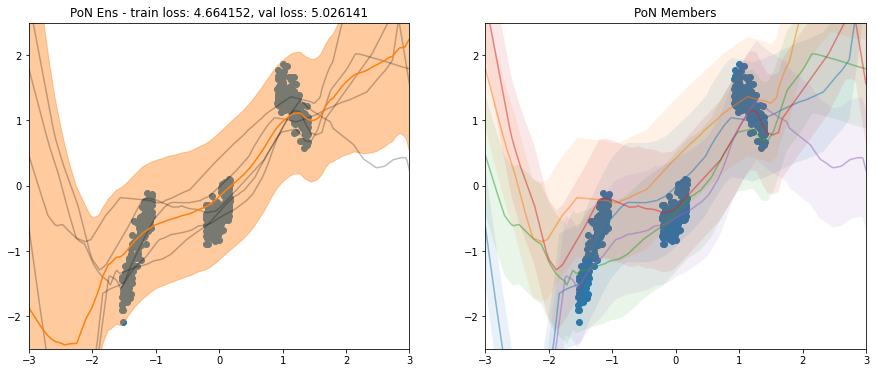

Best val_loss
epoch:  62 - train loss: 4.63571, val_loss: 4.98195, lr: 0.00010
Best val_loss
epoch:  63 - train loss: 4.60850, val_loss: 4.93744, lr: 0.00010
Best val_loss
epoch:  64 - train loss: 4.58051, val_loss: 4.89374, lr: 0.00010
Best val_loss
epoch:  65 - train loss: 4.55351, val_loss: 4.85166, lr: 0.00010
Best val_loss
epoch:  66 - train loss: 4.52685, val_loss: 4.81131, lr: 0.00010
Best val_loss
epoch:  67 - train loss: 4.50009, val_loss: 4.77300, lr: 0.00010
Best val_loss
epoch:  68 - train loss: 4.47271, val_loss: 4.73675, lr: 0.00010
Best val_loss
epoch:  69 - train loss: 4.44529, val_loss: 4.70220, lr: 0.00010
Best val_loss
epoch:  70 - train loss: 4.41738, val_loss: 4.66882, lr: 0.00010
Best val_loss
epoch:  71 - train loss: 4.38987, val_loss: 4.63610, lr: 0.00010
Best val_loss
epoch:  72 - train loss: 4.36264, val_loss: 4.60344, lr: 0.00010
Best val_loss
epoch:  73 - train loss: 4.33578, val_loss: 4.57092, lr: 0.00010
Best val_loss
epoch:  74 - train loss: 4.30876, val_

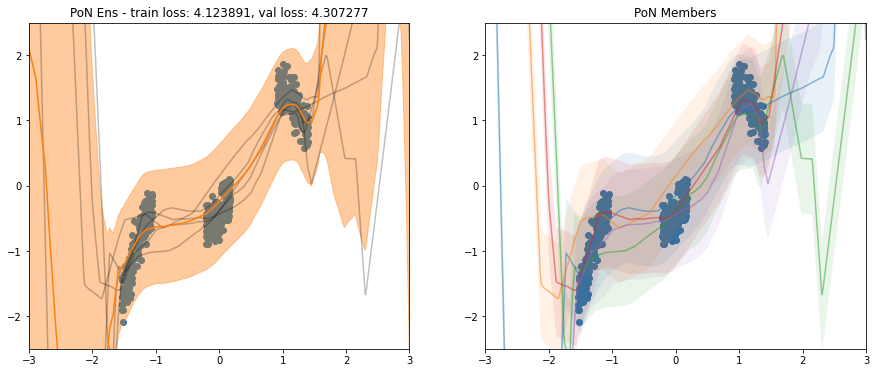

Best val_loss
epoch:  82 - train loss: 4.09782, val_loss: 4.27758, lr: 0.00010
Best val_loss
epoch:  83 - train loss: 4.07195, val_loss: 4.24621, lr: 0.00010
Best val_loss
epoch:  84 - train loss: 4.04609, val_loss: 4.21328, lr: 0.00010
Best val_loss
epoch:  85 - train loss: 4.02032, val_loss: 4.18113, lr: 0.00010
Best val_loss
epoch:  86 - train loss: 3.99461, val_loss: 4.15008, lr: 0.00010
Best val_loss
epoch:  87 - train loss: 3.96911, val_loss: 4.11989, lr: 0.00010
Best val_loss
epoch:  88 - train loss: 3.94378, val_loss: 4.08986, lr: 0.00010
Best val_loss
epoch:  89 - train loss: 3.92322, val_loss: 4.05936, lr: 0.00010
Best val_loss
epoch:  90 - train loss: 3.89390, val_loss: 4.02959, lr: 0.00010
Best val_loss
epoch:  91 - train loss: 3.86929, val_loss: 4.00036, lr: 0.00010
Best val_loss
epoch:  92 - train loss: 3.84499, val_loss: 3.97150, lr: 0.00010
Best val_loss
epoch:  93 - train loss: 3.82071, val_loss: 3.94275, lr: 0.00010
Best val_loss
epoch:  94 - train loss: 3.79658, val_

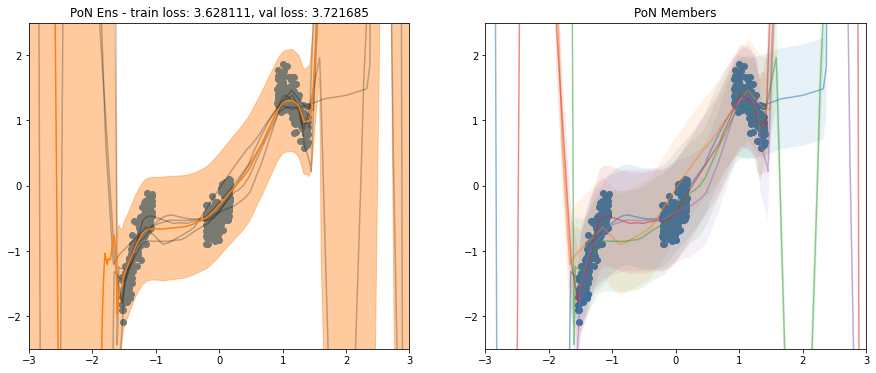

Best val_loss
epoch: 102 - train loss: 3.60427, val_loss: 3.69700, lr: 0.00010
Best val_loss
epoch: 103 - train loss: 3.58035, val_loss: 3.67279, lr: 0.00010
Best val_loss
epoch: 104 - train loss: 3.55633, val_loss: 3.64946, lr: 0.00010
Best val_loss
epoch: 105 - train loss: 3.53250, val_loss: 3.62678, lr: 0.00010
Best val_loss
epoch: 106 - train loss: 3.50862, val_loss: 3.60445, lr: 0.00010
Best val_loss
epoch: 107 - train loss: 3.48477, val_loss: 3.58201, lr: 0.00010
Best val_loss
epoch: 108 - train loss: 3.46111, val_loss: 3.55919, lr: 0.00010
Best val_loss
epoch: 109 - train loss: 3.43761, val_loss: 3.53583, lr: 0.00010
Best val_loss
epoch: 110 - train loss: 3.41420, val_loss: 3.51234, lr: 0.00010
Best val_loss
epoch: 111 - train loss: 3.39077, val_loss: 3.48830, lr: 0.00010
Best val_loss
epoch: 112 - train loss: 3.36752, val_loss: 3.46279, lr: 0.00010
Best val_loss
epoch: 113 - train loss: 3.34415, val_loss: 3.43698, lr: 0.00010
Best val_loss
epoch: 114 - train loss: 3.32077, val_

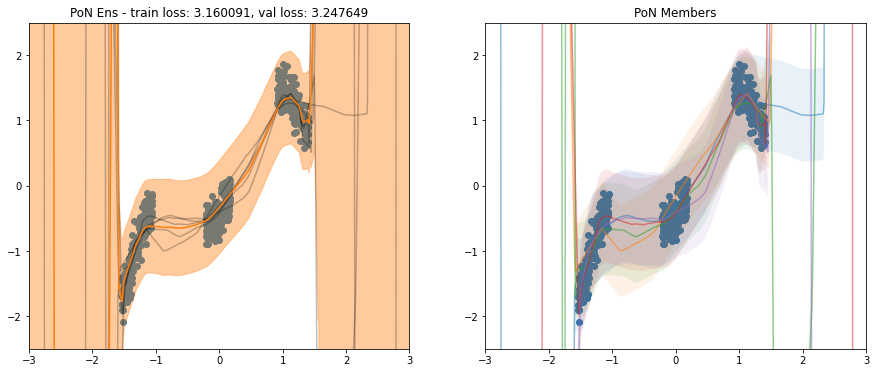

Best val_loss
epoch: 122 - train loss: 3.13778, val_loss: 3.22459, lr: 0.00010
Best val_loss
epoch: 123 - train loss: 3.11522, val_loss: 3.20096, lr: 0.00010
Best val_loss
epoch: 124 - train loss: 3.09278, val_loss: 3.17687, lr: 0.00010
Best val_loss
epoch: 125 - train loss: 3.07009, val_loss: 3.15343, lr: 0.00010
Best val_loss
epoch: 126 - train loss: 3.04755, val_loss: 3.12956, lr: 0.00010
Best val_loss
epoch: 127 - train loss: 3.02532, val_loss: 3.10516, lr: 0.00010
Best val_loss
epoch: 128 - train loss: 3.00270, val_loss: 3.08105, lr: 0.00010
Best val_loss
epoch: 129 - train loss: 2.98045, val_loss: 3.05685, lr: 0.00010
Best val_loss
epoch: 130 - train loss: 2.95805, val_loss: 3.03312, lr: 0.00010
Best val_loss
epoch: 131 - train loss: 2.93558, val_loss: 3.01145, lr: 0.00010
Best val_loss
epoch: 132 - train loss: 2.91352, val_loss: 2.98835, lr: 0.00010
Best val_loss
epoch: 133 - train loss: 2.89132, val_loss: 2.96459, lr: 0.00010
Best val_loss
epoch: 134 - train loss: 2.86936, val_

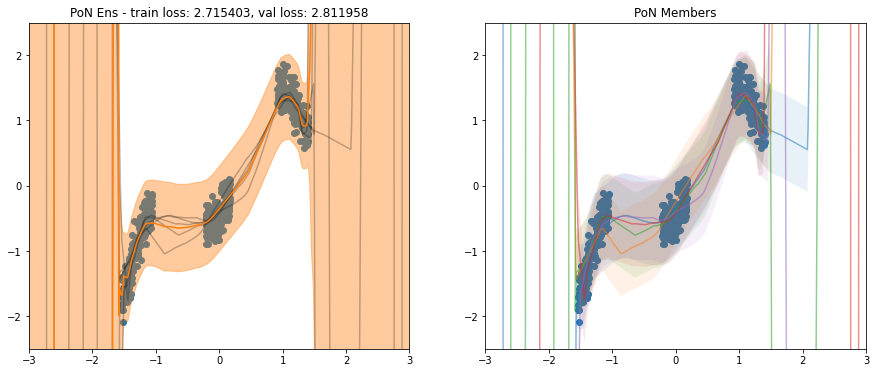

Best val_loss
epoch: 142 - train loss: 2.69326, val_loss: 2.78249, lr: 0.00010
Best val_loss
epoch: 143 - train loss: 2.67112, val_loss: 2.75573, lr: 0.00010
Best val_loss
epoch: 144 - train loss: 2.64919, val_loss: 2.73415, lr: 0.00010
Best val_loss
epoch: 145 - train loss: 2.62738, val_loss: 2.71086, lr: 0.00010
Best val_loss
epoch: 146 - train loss: 2.60560, val_loss: 2.68847, lr: 0.00010
Best val_loss
epoch: 147 - train loss: 2.58400, val_loss: 2.66684, lr: 0.00010
Best val_loss
epoch: 148 - train loss: 2.56235, val_loss: 2.64599, lr: 0.00010
Best val_loss
epoch: 149 - train loss: 2.54059, val_loss: 2.62589, lr: 0.00010
Best val_loss
epoch: 150 - train loss: 2.51895, val_loss: 2.60493, lr: 0.00010
Best val_loss
epoch: 151 - train loss: 2.49747, val_loss: 2.58486, lr: 0.00010
Best val_loss
epoch: 152 - train loss: 2.47594, val_loss: 2.56501, lr: 0.00010
Best val_loss
epoch: 153 - train loss: 2.45451, val_loss: 2.54344, lr: 0.00010
Best val_loss
epoch: 154 - train loss: 2.43306, val_

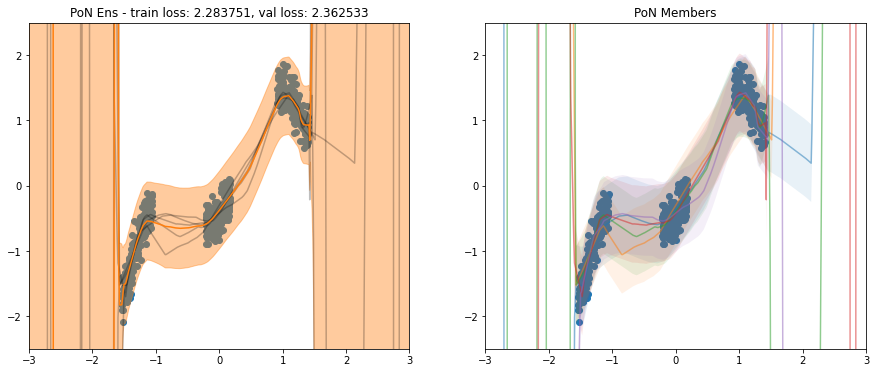

Best val_loss
epoch: 162 - train loss: 2.26242, val_loss: 2.34198, lr: 0.00010
Best val_loss
epoch: 163 - train loss: 2.24144, val_loss: 2.32105, lr: 0.00010
Best val_loss
epoch: 164 - train loss: 2.22030, val_loss: 2.29939, lr: 0.00010
Best val_loss
epoch: 165 - train loss: 2.19931, val_loss: 2.27707, lr: 0.00010
Best val_loss
epoch: 166 - train loss: 2.17824, val_loss: 2.25493, lr: 0.00010
Best val_loss
epoch: 167 - train loss: 2.15741, val_loss: 2.23325, lr: 0.00010
Best val_loss
epoch: 168 - train loss: 2.13643, val_loss: 2.21180, lr: 0.00010
Best val_loss
epoch: 169 - train loss: 2.11554, val_loss: 2.19066, lr: 0.00010
Best val_loss
epoch: 170 - train loss: 2.09466, val_loss: 2.16964, lr: 0.00010
Best val_loss
epoch: 171 - train loss: 2.07382, val_loss: 2.14873, lr: 0.00010
Best val_loss
epoch: 172 - train loss: 2.05298, val_loss: 2.12787, lr: 0.00010
Best val_loss
epoch: 173 - train loss: 2.03221, val_loss: 2.10695, lr: 0.00010
Best val_loss
epoch: 174 - train loss: 2.01154, val_

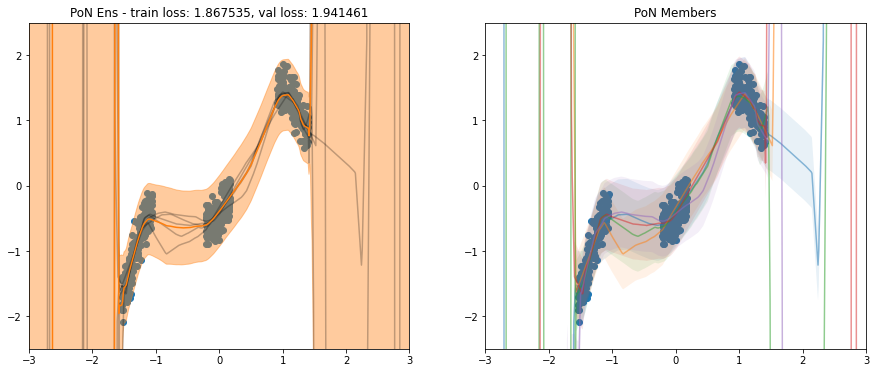

Best val_loss
epoch: 182 - train loss: 1.84714, val_loss: 1.92151, lr: 0.00010
Best val_loss
epoch: 183 - train loss: 1.82684, val_loss: 1.90154, lr: 0.00010
Best val_loss
epoch: 184 - train loss: 1.80649, val_loss: 1.88158, lr: 0.00010
Best val_loss
epoch: 185 - train loss: 1.78623, val_loss: 1.86164, lr: 0.00010
Best val_loss
epoch: 186 - train loss: 1.76606, val_loss: 1.84170, lr: 0.00010
Best val_loss
epoch: 187 - train loss: 1.74585, val_loss: 1.82194, lr: 0.00010
Best val_loss
epoch: 188 - train loss: 1.72564, val_loss: 1.80204, lr: 0.00010
Best val_loss
epoch: 189 - train loss: 1.70567, val_loss: 1.78212, lr: 0.00010
Best val_loss
epoch: 190 - train loss: 1.68562, val_loss: 1.76236, lr: 0.00010
Best val_loss
epoch: 191 - train loss: 1.66561, val_loss: 1.74270, lr: 0.00010
Best val_loss
epoch: 192 - train loss: 1.64556, val_loss: 1.72292, lr: 0.00010
Best val_loss
epoch: 193 - train loss: 1.62550, val_loss: 1.70301, lr: 0.00010
Best val_loss
epoch: 194 - train loss: 1.60549, val_

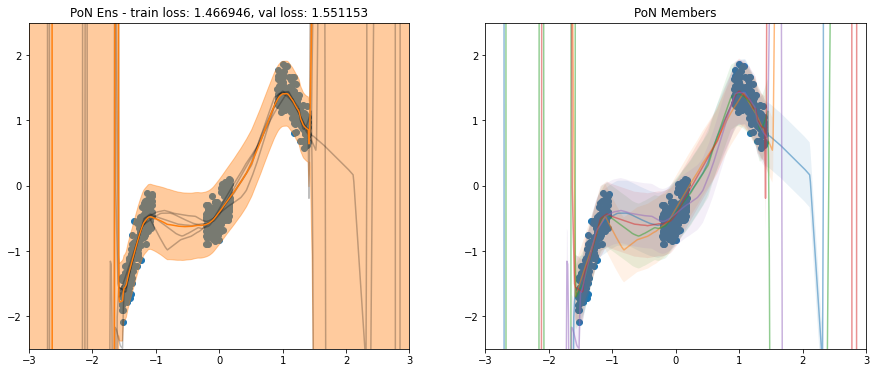

Best val_loss


+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 9.91022, val_loss: 8.01718, lr: 0.00010


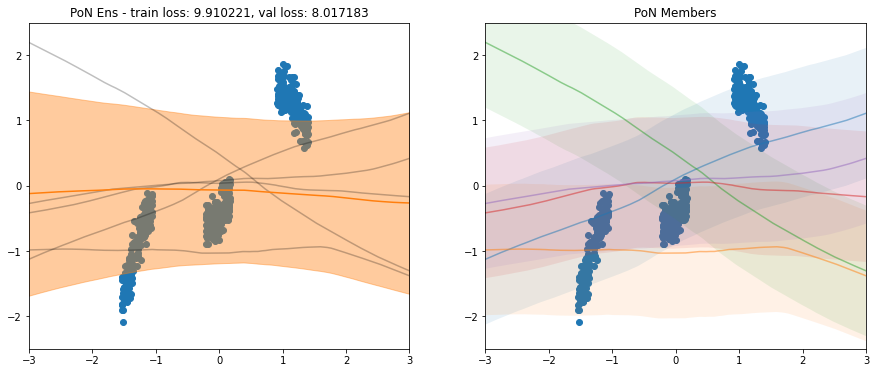

Best val_loss
epoch:   2 - train loss: 9.43830, val_loss: 7.93653, lr: 0.00010
Best val_loss
epoch:   3 - train loss: 9.18338, val_loss: 7.84046, lr: 0.00010
Best val_loss
epoch:   4 - train loss: 8.83571, val_loss: 7.73235, lr: 0.00010
Best val_loss
epoch:   5 - train loss: 8.51796, val_loss: 7.61308, lr: 0.00010
Best val_loss
epoch:   6 - train loss: 8.19780, val_loss: 7.48479, lr: 0.00010
Best val_loss
epoch:   7 - train loss: 7.76934, val_loss: 7.33021, lr: 0.00010
Best val_loss
epoch:   8 - train loss: 7.21305, val_loss: 7.18151, lr: 0.00010
Best val_loss
epoch:   9 - train loss: 6.93172, val_loss: 7.03773, lr: 0.00010
Best val_loss
epoch:  10 - train loss: 6.67058, val_loss: 6.89878, lr: 0.00010
Best val_loss
epoch:  11 - train loss: 6.41502, val_loss: 6.76671, lr: 0.00010
Best val_loss
epoch:  12 - train loss: 6.20155, val_loss: 6.64151, lr: 0.00010
Best val_loss
epoch:  13 - train loss: 6.02095, val_loss: 6.52345, lr: 0.00010
Best val_loss
epoch:  14 - train loss: 5.89503, val_

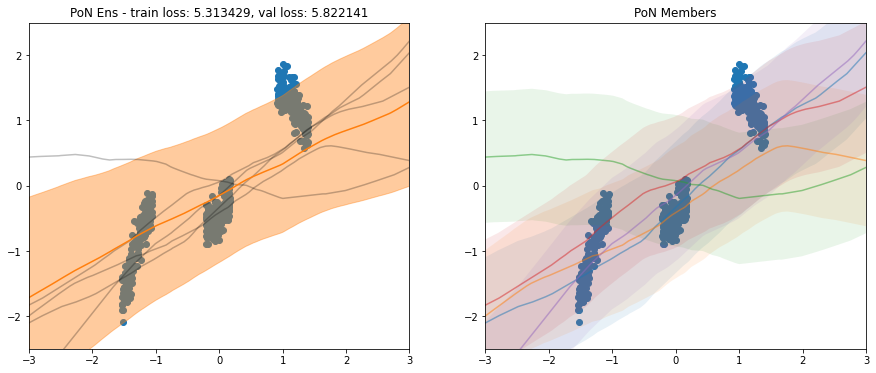

Best val_loss
epoch:  22 - train loss: 5.27500, val_loss: 5.76254, lr: 0.00010
Best val_loss
epoch:  23 - train loss: 5.23953, val_loss: 5.70826, lr: 0.00010
Best val_loss
epoch:  24 - train loss: 5.20704, val_loss: 5.65843, lr: 0.00010
Best val_loss
epoch:  25 - train loss: 5.17532, val_loss: 5.61233, lr: 0.00010
Best val_loss
epoch:  26 - train loss: 5.14549, val_loss: 5.56999, lr: 0.00010
Best val_loss
epoch:  27 - train loss: 5.11593, val_loss: 5.53090, lr: 0.00010
Best val_loss
epoch:  28 - train loss: 5.08724, val_loss: 5.49440, lr: 0.00010
Best val_loss
epoch:  29 - train loss: 5.05826, val_loss: 5.46003, lr: 0.00010
Best val_loss
epoch:  30 - train loss: 5.02977, val_loss: 5.42735, lr: 0.00010
Best val_loss
epoch:  31 - train loss: 5.00167, val_loss: 5.39590, lr: 0.00010
Best val_loss
epoch:  32 - train loss: 4.97463, val_loss: 5.36503, lr: 0.00010
Best val_loss
epoch:  33 - train loss: 4.94852, val_loss: 5.33423, lr: 0.00010
Best val_loss
epoch:  34 - train loss: 4.92290, val_

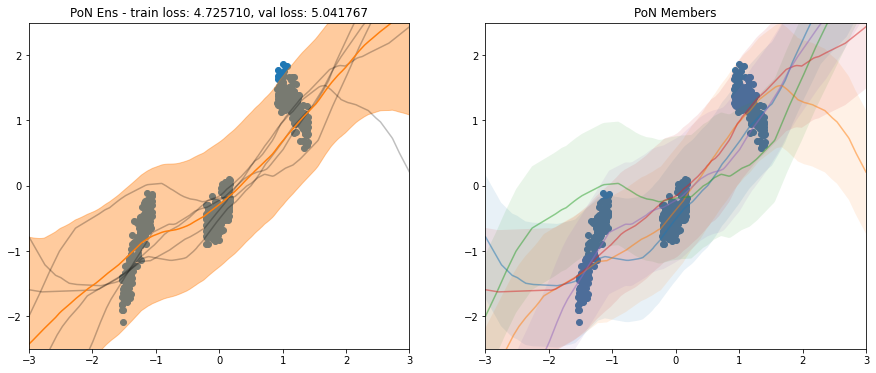

Best val_loss
epoch:  42 - train loss: 4.69765, val_loss: 4.99914, lr: 0.00010
Best val_loss
epoch:  43 - train loss: 4.67123, val_loss: 4.95568, lr: 0.00010
Best val_loss
epoch:  44 - train loss: 4.64465, val_loss: 4.91176, lr: 0.00010
Best val_loss
epoch:  45 - train loss: 4.61655, val_loss: 4.86726, lr: 0.00010
Best val_loss
epoch:  46 - train loss: 4.58691, val_loss: 4.82320, lr: 0.00010
Best val_loss
epoch:  47 - train loss: 4.55694, val_loss: 4.78017, lr: 0.00010
Best val_loss
epoch:  48 - train loss: 4.52885, val_loss: 4.73874, lr: 0.00010
Best val_loss
epoch:  49 - train loss: 4.50247, val_loss: 4.69939, lr: 0.00010
Best val_loss
epoch:  50 - train loss: 4.47677, val_loss: 4.66224, lr: 0.00010
Best val_loss
epoch:  51 - train loss: 4.45159, val_loss: 4.62744, lr: 0.00010
Best val_loss
epoch:  52 - train loss: 4.42644, val_loss: 4.59485, lr: 0.00010
Best val_loss
epoch:  53 - train loss: 4.40108, val_loss: 4.56390, lr: 0.00010
Best val_loss
epoch:  54 - train loss: 4.37668, val_

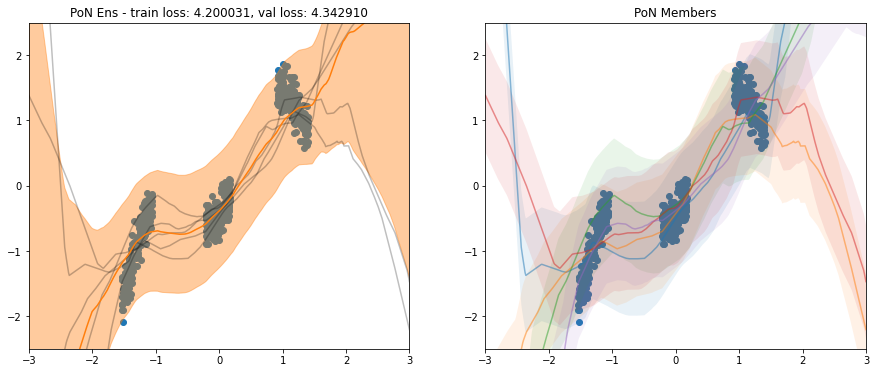

Best val_loss
epoch:  62 - train loss: 4.17615, val_loss: 4.31421, lr: 0.00010
Best val_loss
epoch:  63 - train loss: 4.15229, val_loss: 4.28481, lr: 0.00010
Best val_loss
epoch:  64 - train loss: 4.12850, val_loss: 4.25486, lr: 0.00010
Best val_loss
epoch:  65 - train loss: 4.10459, val_loss: 4.22452, lr: 0.00010
Best val_loss
epoch:  66 - train loss: 4.08045, val_loss: 4.19408, lr: 0.00010
Best val_loss
epoch:  67 - train loss: 4.05640, val_loss: 4.16368, lr: 0.00010
Best val_loss
epoch:  68 - train loss: 4.03240, val_loss: 4.13350, lr: 0.00010
Best val_loss
epoch:  69 - train loss: 4.00849, val_loss: 4.10311, lr: 0.00010
Best val_loss
epoch:  70 - train loss: 3.98451, val_loss: 4.07296, lr: 0.00010
Best val_loss
epoch:  71 - train loss: 3.96076, val_loss: 4.04299, lr: 0.00010
Best val_loss
epoch:  72 - train loss: 3.93712, val_loss: 4.01388, lr: 0.00010
Best val_loss
epoch:  73 - train loss: 3.91356, val_loss: 3.98539, lr: 0.00010
Best val_loss
epoch:  74 - train loss: 3.89022, val_

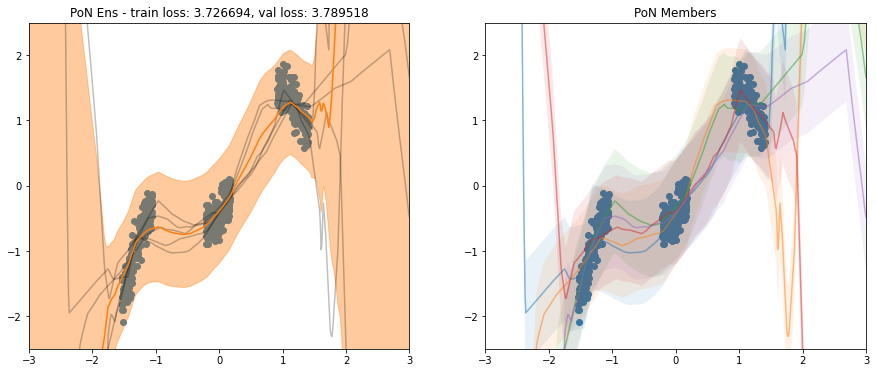

Best val_loss
epoch:  82 - train loss: 3.70361, val_loss: 3.76719, lr: 0.00010
Best val_loss
epoch:  83 - train loss: 3.68060, val_loss: 3.74487, lr: 0.00010
Best val_loss
epoch:  84 - train loss: 3.65765, val_loss: 3.72250, lr: 0.00010
Best val_loss
epoch:  85 - train loss: 3.63471, val_loss: 3.70007, lr: 0.00010
Best val_loss
epoch:  86 - train loss: 3.61177, val_loss: 3.67752, lr: 0.00010
Best val_loss
epoch:  87 - train loss: 3.58891, val_loss: 3.65486, lr: 0.00010
Best val_loss
epoch:  88 - train loss: 3.56609, val_loss: 3.63210, lr: 0.00010
Best val_loss
epoch:  89 - train loss: 3.54334, val_loss: 3.60941, lr: 0.00010
Best val_loss
epoch:  90 - train loss: 3.52059, val_loss: 3.58684, lr: 0.00010
Best val_loss
epoch:  91 - train loss: 3.49793, val_loss: 3.56442, lr: 0.00010
Best val_loss
epoch:  92 - train loss: 3.47530, val_loss: 3.54227, lr: 0.00010
Best val_loss
epoch:  93 - train loss: 3.45273, val_loss: 3.52056, lr: 0.00010
Best val_loss
epoch:  94 - train loss: 3.43019, val_

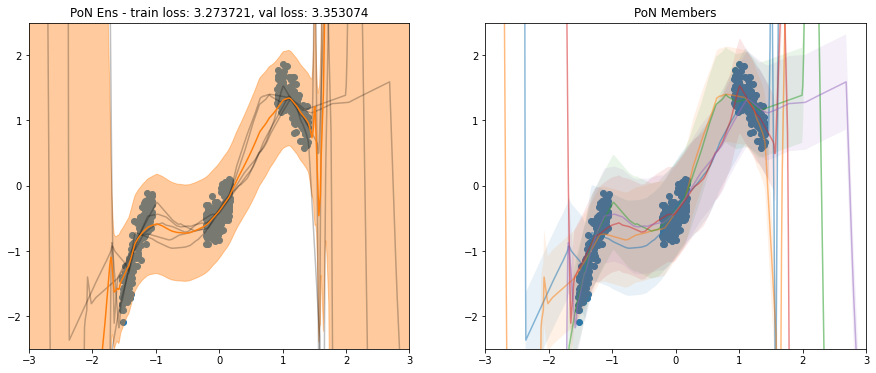

Best val_loss
epoch: 102 - train loss: 3.25149, val_loss: 3.33177, lr: 0.00010
Best val_loss
epoch: 103 - train loss: 3.22931, val_loss: 3.31016, lr: 0.00010
Best val_loss
epoch: 104 - train loss: 3.20714, val_loss: 3.28840, lr: 0.00010
Best val_loss
epoch: 105 - train loss: 3.18496, val_loss: 3.26649, lr: 0.00010
Best val_loss
epoch: 106 - train loss: 3.16282, val_loss: 3.24448, lr: 0.00010
Best val_loss
epoch: 107 - train loss: 3.14066, val_loss: 3.22239, lr: 0.00010
Best val_loss
epoch: 108 - train loss: 3.11855, val_loss: 3.20038, lr: 0.00010
Best val_loss
epoch: 109 - train loss: 3.09646, val_loss: 3.17828, lr: 0.00010
Best val_loss
epoch: 110 - train loss: 3.07438, val_loss: 3.15620, lr: 0.00010
Best val_loss
epoch: 111 - train loss: 3.05234, val_loss: 3.13428, lr: 0.00010
Best val_loss
epoch: 112 - train loss: 3.03032, val_loss: 3.11258, lr: 0.00010
Best val_loss
epoch: 113 - train loss: 3.00828, val_loss: 3.09105, lr: 0.00010
Best val_loss
epoch: 114 - train loss: 2.98641, val_

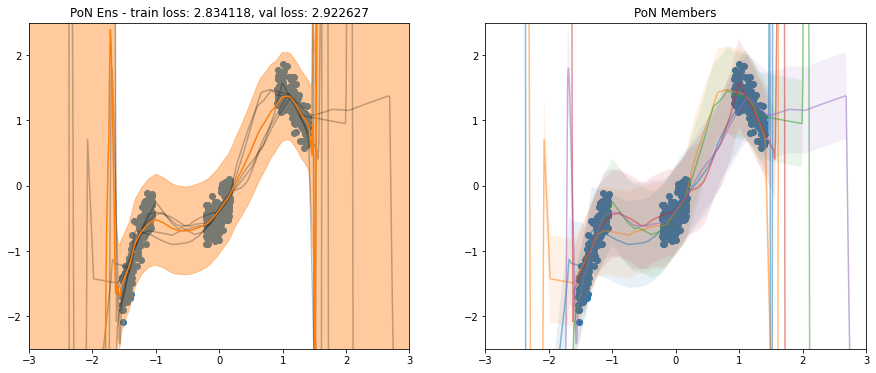

Best val_loss
epoch: 122 - train loss: 2.81233, val_loss: 2.90172, lr: 0.00010
Best val_loss
epoch: 123 - train loss: 2.79068, val_loss: 2.88104, lr: 0.00010
Best val_loss
epoch: 124 - train loss: 2.76906, val_loss: 2.86041, lr: 0.00010
Best val_loss
epoch: 125 - train loss: 2.74747, val_loss: 2.83983, lr: 0.00010
Best val_loss
epoch: 126 - train loss: 2.72593, val_loss: 2.81922, lr: 0.00010
Best val_loss
epoch: 127 - train loss: 2.70443, val_loss: 2.79850, lr: 0.00010
Best val_loss
epoch: 128 - train loss: 2.68300, val_loss: 2.77773, lr: 0.00010
Best val_loss
epoch: 129 - train loss: 2.66163, val_loss: 2.75670, lr: 0.00010
Best val_loss
epoch: 130 - train loss: 2.64024, val_loss: 2.73545, lr: 0.00010
Best val_loss
epoch: 131 - train loss: 2.61874, val_loss: 2.71405, lr: 0.00010
Best val_loss
epoch: 132 - train loss: 2.59731, val_loss: 2.69257, lr: 0.00010
Best val_loss
epoch: 133 - train loss: 2.57598, val_loss: 2.67086, lr: 0.00010
Best val_loss
epoch: 134 - train loss: 2.55464, val_

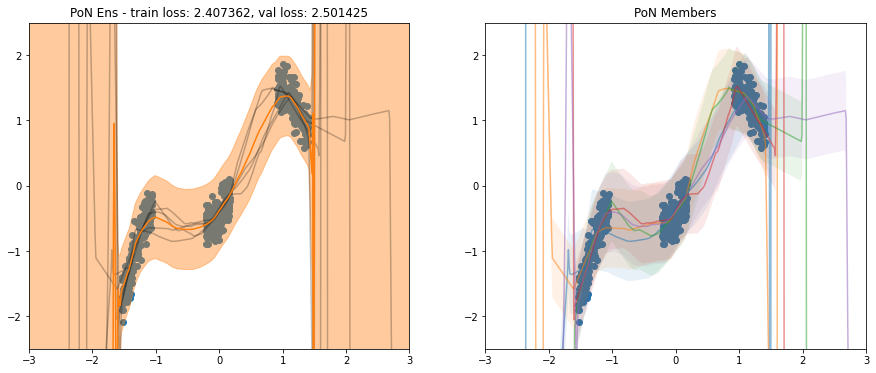

Best val_loss
epoch: 142 - train loss: 2.38647, val_loss: 2.48111, lr: 0.00010
Best val_loss
epoch: 143 - train loss: 2.36575, val_loss: 2.46102, lr: 0.00010
Best val_loss
epoch: 144 - train loss: 2.34491, val_loss: 2.44115, lr: 0.00010
Best val_loss
epoch: 145 - train loss: 2.32411, val_loss: 2.42152, lr: 0.00010
Best val_loss
epoch: 146 - train loss: 2.30325, val_loss: 2.40196, lr: 0.00010
Best val_loss
epoch: 147 - train loss: 2.28253, val_loss: 2.38236, lr: 0.00010
Best val_loss
epoch: 148 - train loss: 2.26184, val_loss: 2.36270, lr: 0.00010
Best val_loss
epoch: 149 - train loss: 2.24118, val_loss: 2.34304, lr: 0.00010
Best val_loss
epoch: 150 - train loss: 2.22048, val_loss: 2.32344, lr: 0.00010
Best val_loss
epoch: 151 - train loss: 2.19977, val_loss: 2.30397, lr: 0.00010
Best val_loss
epoch: 152 - train loss: 2.17921, val_loss: 2.28440, lr: 0.00010
Best val_loss
epoch: 153 - train loss: 2.15859, val_loss: 2.26478, lr: 0.00010
Best val_loss
epoch: 154 - train loss: 2.13810, val_

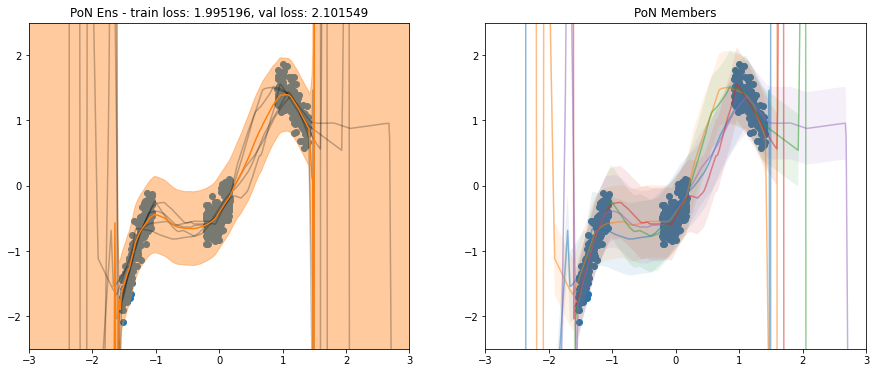

Best val_loss
epoch: 162 - train loss: 1.97507, val_loss: 2.08134, lr: 0.00010
Best val_loss
epoch: 163 - train loss: 1.95496, val_loss: 2.06143, lr: 0.00010
Best val_loss
epoch: 164 - train loss: 1.93480, val_loss: 2.04175, lr: 0.00010
Best val_loss
epoch: 165 - train loss: 1.91470, val_loss: 2.02236, lr: 0.00010
Best val_loss
epoch: 166 - train loss: 1.89464, val_loss: 2.00319, lr: 0.00010
Best val_loss
epoch: 167 - train loss: 1.87469, val_loss: 1.98393, lr: 0.00010
Best val_loss
epoch: 168 - train loss: 1.85471, val_loss: 1.96436, lr: 0.00010
Best val_loss
epoch: 169 - train loss: 1.83490, val_loss: 1.94476, lr: 0.00010
Best val_loss
epoch: 170 - train loss: 1.81512, val_loss: 1.92502, lr: 0.00010
Best val_loss
epoch: 171 - train loss: 1.79537, val_loss: 1.90504, lr: 0.00010
Best val_loss
epoch: 172 - train loss: 1.77560, val_loss: 1.88478, lr: 0.00010
Best val_loss
epoch: 173 - train loss: 1.75582, val_loss: 1.86420, lr: 0.00010
Best val_loss
epoch: 174 - train loss: 1.73621, val_

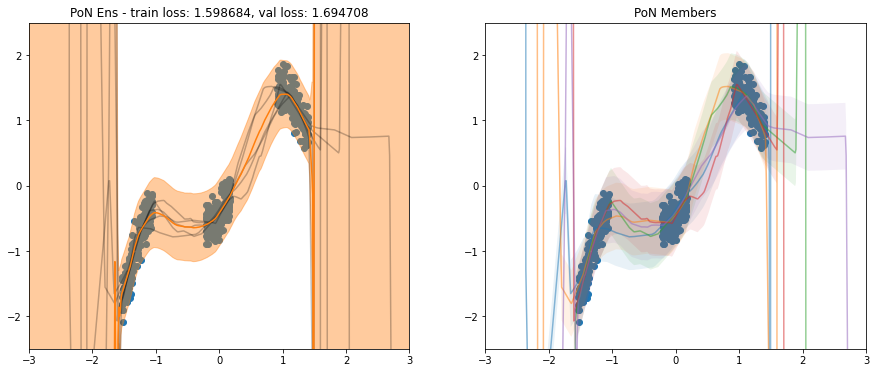

Best val_loss
epoch: 182 - train loss: 1.57921, val_loss: 1.67416, lr: 0.00010
Best val_loss
epoch: 183 - train loss: 1.55976, val_loss: 1.65401, lr: 0.00010
Best val_loss
epoch: 184 - train loss: 1.54030, val_loss: 1.63427, lr: 0.00010
Best val_loss
epoch: 185 - train loss: 1.52095, val_loss: 1.61505, lr: 0.00010
Best val_loss
epoch: 186 - train loss: 1.50156, val_loss: 1.59612, lr: 0.00010
Best val_loss
epoch: 187 - train loss: 1.48224, val_loss: 1.57761, lr: 0.00010
Best val_loss
epoch: 188 - train loss: 1.46295, val_loss: 1.55949, lr: 0.00010
Best val_loss
epoch: 189 - train loss: 1.44361, val_loss: 1.54155, lr: 0.00010
Best val_loss
epoch: 190 - train loss: 1.42422, val_loss: 1.52353, lr: 0.00010
Best val_loss
epoch: 191 - train loss: 1.40501, val_loss: 1.50470, lr: 0.00010
Best val_loss
epoch: 192 - train loss: 1.38591, val_loss: 1.48603, lr: 0.00010
Best val_loss
epoch: 193 - train loss: 1.36687, val_loss: 1.46781, lr: 0.00010
Best val_loss
epoch: 194 - train loss: 1.34782, val_

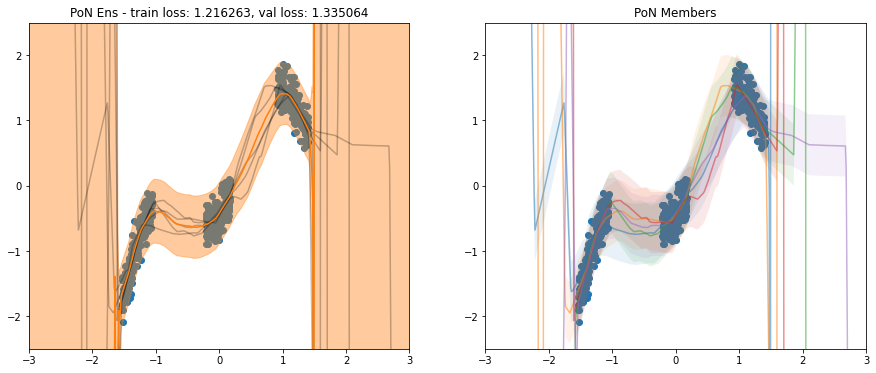

Best val_loss


In [9]:
config = get_pon_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_pon_states = []
for i in range(3):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    pon_model, state = setup_training(config, setup_rng, init_x, init_y)

    if RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            pon_model, state, config, rng, make_PoN_Ens_loss, make_PoN_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_PoN_Ens_plots,
        )

        best_pon_states.append(best_state)

In [10]:
if RETRAIN:  # RETRAIN
    save_checkpoint('pon_models', best_pon_states, 1, overwrite=True)

## Paper Plots

In [11]:
restored_pog_models = restore_checkpoint('pog_models', 1)
restored_ens_models = restore_checkpoint('ens_models', 1)
restored_pon_models = restore_checkpoint('pon_models', 1)

In [12]:
text_width = 6.75133 # in  --> Confirmed with template explanation
line_width = 3.25063
dpi = 400

fs_m1 = 7  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_1623906/821981954.py:20: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [13]:
X_test, y_test = list(zip(*test_loader.dataset))

In [14]:
def uniform_entropy(loc, scale):
    upper = loc + scale
    lower = loc - scale
    # return jnp.log(upper - lower)
    uni = distrax.Uniform(lower, upper)
    return uni.entropy()

def uniform_nll(loc, scale, y):
    upper = loc + scale
    lower = loc - scale
    # return jnp.log(upper - lower)
    uni = distrax.Uniform(lower, upper)
    return -uni.log_prob(y)

In [15]:
def normal_entropy(loc, scale):
    norm = distrax.Normal(loc, scale)
    return norm.entropy()

def normal_nll(loc, scale, y):
    norm = distrax.Normal(loc, scale)
    return -norm.log_prob(y)

In [16]:
def mse(loc, y):
    return jnp.mean((loc - y)**2)

In [17]:
results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'mse', 'nll'])
results_df

Empty DataFrame
Columns: [model_name, n_members, random_seed, H, mse, nll]
Index: []

In [18]:
s = set(range(5))
power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

for (model, model_name) in [(pog_model, 'PoG'), (ens_model, 'Ens'), (pon_model, 'PoN')]:
    for i in range(3):
        if model_name == 'PoG':
            state = restored_pog_models[f'{i}']
        elif model_name == 'Ens':
            state = restored_ens_models[f'{i}']
        elif model_name == 'PoN':
            state = restored_pon_models[f'{i}']
        
        pred_fun = partial(
            model.apply,
            {"params": state['params'], **state['model_state']},
            train=False, return_ens_preds=True,
            method=model.pred
        )
        _, (locs, scales) = jax.vmap(
            pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
        )(jnp.array(X_test))

        for indices in power_set:
            n_members = len(indices)

            if model_name == 'PoG':
                loc, scale = calculate_pog_loc_scale(locs[indices, :, 0], scales[indices, :, 0])
                entropies = jax.vmap(uniform_entropy)(loc, scale)
                nlls_ = jax.vmap(uniform_nll)(loc, scale, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                print(f"dropping {infs.sum()} infs for prod of {n_members}")
                nlls = nlls_[~infs]
            elif model_name == 'Ens':
                loc, scale = calculate_ens_loc_scale(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                entropies = jax.vmap(normal_entropy)(loc, scale)
                nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
            elif model_name == 'PoN':
                loc, scale = normal_prod(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                entropies = jax.vmap(normal_entropy)(loc, scale)
                nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
            
            errors = jax.vmap(mse)(loc, jnp.array(y_test))

            results_df = pd.concat([
                results_df,
                pd.DataFrame({
                    'model_name': [model_name],
                    'n_members': [n_members],
                    'random_seed': [i],
                    'H': [entropies.mean()],
                    'nll': [nlls.mean()],
                    'mse': [errors.mean()],
                })],
                ignore_index=True
            )

dropping 3 infs for prod of 1
dropping 1 infs for prod of 1
dropping 1 infs for prod of 1
dropping 3 infs for prod of 1
dropping 2 infs for prod of 1
dropping 4 infs for prod of 2
dropping 4 infs for prod of 2
dropping 6 infs for prod of 2
dropping 4 infs for prod of 2
dropping 2 infs for prod of 2
dropping 4 infs for prod of 2
dropping 3 infs for prod of 2
dropping 3 infs for prod of 2
dropping 3 infs for prod of 2
dropping 5 infs for prod of 2
dropping 5 infs for prod of 3
dropping 7 infs for prod of 3
dropping 5 infs for prod of 3
dropping 6 infs for prod of 3
dropping 5 infs for prod of 3
dropping 7 infs for prod of 3
dropping 4 infs for prod of 3
dropping 4 infs for prod of 3
dropping 6 infs for prod of 3
dropping 5 infs for prod of 3
dropping 7 infs for prod of 4
dropping 6 infs for prod of 4
dropping 8 infs for prod of 4
dropping 7 infs for prod of 4
dropping 6 infs for prod of 4
dropping 8 infs for prod of 5
dropping 0 infs for prod of 1
dropping 3 infs for prod of 1
dropping 4

In [19]:
min_mse_df = results_df[results_df.n_members == 5][['model_name', 'random_seed', 'mse', 'nll']].rename(
    columns={'mse': 'final_mse', 'nll': 'final_nll'}
)
min_mse_df

model_name random_seed    final_mse    final_nll
30         PoG           0  0.030734057  -0.45719996
61         PoG           1  0.031202642   -0.5432881
92         PoG           2  0.032145027  -0.43486643
123        Ens           0  0.030162511   0.23965847
154        Ens           1  0.030695308   0.29023746
185        Ens           2  0.029974848   0.23560788
216        PoN           0  0.030162508   0.23834138
247        PoN           1  0.030695312   0.28249183
278        PoN           2  0.029974855   0.22843148

In [20]:
tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
tmp_df['mse_diff'] = tmp_df['mse'] - tmp_df['final_mse'] 
tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
tmp_df

model_name n_members random_seed           H          mse         nll  \
0          PoG         1           0  0.79892766   0.48162416  0.79892755   
1          PoG         1           0  0.79892766   0.34251088  0.79892755   
2          PoG         1           0  0.79892766    0.5796242  0.79892755   
3          PoG         1           0  0.79892766   0.45725384  0.79892755   
4          PoG         1           0  0.79892766   0.41920272  0.79892755   
..         ...       ...         ...         ...          ...         ...   
274        PoN         4           2    0.660059   0.03047457  0.22957133   
275        PoN         4           2    0.660059    0.0306262   0.2299172   
276        PoN         4           2    0.660059  0.029866993  0.22818545   
277        PoN         4           2    0.660059  0.029208709  0.22668393   
278        PoN         5           2    0.660059  0.029974855  0.22843148   

       final_mse    final_nll         mse_diff        nll_diff  
0    0.030734057  -0.45719996        0.4508901       1.2561275  
1    0.030734057  -0.45719996       0.31177682       1.2561275  
2    0.030734057  -0.45719996        0.5488901       1.2561275  
3    0.030734057  -0.45719996       0.42651978       1.2561275  
4    0.030734057  -0.45719996       0.38846865       1.2561275  
..           ...          ...              ...             ...  
274  0.029974855   0.22843148    0.00049971417    0.0011398494  
275  0.029974855   0.22843148    0.00065134466    0.0014857203  
276  0.029974855   0.22843148  -0.000107862055  -0.00024603307  
277  0.029974855   0.22843148    -0.0007661469   -0.0017475486  
278  0.029974855   0.22843148              0.0             0.0  

[279 rows x 10 columns]

In [21]:
agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'mse_diff': ['mean', 'std', 'count'],
    'mse': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
})
agg_df

H                  mse_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.683845  0.027184    15  0.003026  0.004938    15   
           2          0.687521  0.027596    30  0.001135  0.001518    30   
           3          0.688787  0.027871    30  0.000504  0.000743    30   
           4          0.689459  0.028520    15  0.000189  0.000399    15   
           5          0.689881  0.033866     3  0.000000  0.000000     3   
PoG        1          0.796299  0.049246    15  0.422219  0.104343    15   
           2          0.259073  0.217680    30  0.185336  0.098930    30   
           3         -0.077704  0.186136    30  0.083010  0.065178    30   
           4         -0.310381  0.129449    15  0.030555  0.038595    15   
           5         -0.482516  0.057965     3  0.000000  0.000000     3   
PoN        1          0.683845  0.027184    15  0.003026  0.004938    15   
           2          0.683845  0.026711    30  0.001135  0.001518    30   
           3          0.683845  0.026711    30  0.000504  0.000743    30   
           4          0.683845  0.027184    15  0.000189  0.000399    15   
           5          0.683845  0.032165     3  0.000000  0.000000     3   

                           mse                      nll_diff                  \
                          mean       std count          mean       std count   
model_name n_members                                                           
Ens        1          0.033303  0.005006    15  1.066241e-03  0.009871    15   
           2          0.031412  0.001615    30  4.666994e-05  0.004879    30   
           3          0.030782  0.000861    30 -1.142422e-07  0.003254    30   
           4          0.030467  0.000543    15 -2.585848e-06  0.002039    15   
           5          0.030278  0.000374     3  0.000000e+00  0.000000     3   
PoG        1          0.453580  0.104088    15  1.274751e+00  0.095997    15   
           2          0.216696  0.098835    30  7.450043e-01  0.228084    30   
           3          0.114371  0.065133    30  4.100021e-01  0.198342    30   
           4          0.061915  0.038589    15  1.755903e-01  0.138653    15   
           5          0.031361  0.000719     3  0.000000e+00  0.000000     3   
PoN        1          0.033303  0.005006    15  6.479255e-03  0.010508    15   
           2          0.031412  0.001615    30  2.429716e-03  0.003325    30   
           3          0.030782  0.000861    30  1.079863e-03  0.001654    30   
           4          0.030467  0.000543    15  4.049540e-04  0.000891    15   
           5          0.030278  0.000374     3  0.000000e+00  0.000000     3   

                           nll                  
                          mean       std count  
model_name n_members                            
Ens        1          0.256234  0.028073    15  
           2          0.255215  0.025554    30  
           3          0.255168  0.025390    30  
           4          0.255165  0.025769    15  
           5          0.255168  0.030439     3  
PoG        1          0.796299  0.049246    15  
           2          0.266553  0.214589    30  
           3         -0.068449  0.185284    30  
           4         -0.302861  0.130455    15  
           5         -0.478451  0.057250     3  
PoN        1          0.256234  0.028073    15  
           2          0.252185  0.024768    30  
           3          0.250835  0.024245    30  
           4          0.250160  0.024451    15  
           5          0.249755  0.028781     3

In [22]:
agg_df[('H', 'std_err')] = agg_df[('H', 'std')] / agg_df[('H', 'count')]
agg_df[('mse_diff', 'std_err')] = agg_df[('mse_diff', 'std')] / agg_df[('mse_diff', 'count')]
agg_df[('mse', 'std_err')] = agg_df[('mse', 'std')] / agg_df[('mse', 'count')]
agg_df[('nll_diff', 'std_err')] = agg_df[('nll_diff', 'std')] / agg_df[('nll_diff', 'count')]
agg_df[('nll', 'std_err')] = agg_df[('nll', 'std')] / agg_df[('nll', 'count')]
agg_df

H                  mse_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.683845  0.027184    15  0.003026  0.004938    15   
           2          0.687521  0.027596    30  0.001135  0.001518    30   
           3          0.688787  0.027871    30  0.000504  0.000743    30   
           4          0.689459  0.028520    15  0.000189  0.000399    15   
           5          0.689881  0.033866     3  0.000000  0.000000     3   
PoG        1          0.796299  0.049246    15  0.422219  0.104343    15   
           2          0.259073  0.217680    30  0.185336  0.098930    30   
           3         -0.077704  0.186136    30  0.083010  0.065178    30   
           4         -0.310381  0.129449    15  0.030555  0.038595    15   
           5         -0.482516  0.057965     3  0.000000  0.000000     3   
PoN        1          0.683845  0.027184    15  0.003026  0.004938    15   
           2          0.683845  0.026711    30  0.001135  0.001518    30   
           3          0.683845  0.026711    30  0.000504  0.000743    30   
           4          0.683845  0.027184    15  0.000189  0.000399    15   
           5          0.683845  0.032165     3  0.000000  0.000000     3   

                           mse                      nll_diff                  \
                          mean       std count          mean       std count   
model_name n_members                                                           
Ens        1          0.033303  0.005006    15  1.066241e-03  0.009871    15   
           2          0.031412  0.001615    30  4.666994e-05  0.004879    30   
           3          0.030782  0.000861    30 -1.142422e-07  0.003254    30   
           4          0.030467  0.000543    15 -2.585848e-06  0.002039    15   
           5          0.030278  0.000374     3  0.000000e+00  0.000000     3   
PoG        1          0.453580  0.104088    15  1.274751e+00  0.095997    15   
           2          0.216696  0.098835    30  7.450043e-01  0.228084    30   
           3          0.114371  0.065133    30  4.100021e-01  0.198342    30   
           4          0.061915  0.038589    15  1.755903e-01  0.138653    15   
           5          0.031361  0.000719     3  0.000000e+00  0.000000     3   
PoN        1          0.033303  0.005006    15  6.479255e-03  0.010508    15   
           2          0.031412  0.001615    30  2.429716e-03  0.003325    30   
           3          0.030782  0.000861    30  1.079863e-03  0.001654    30   
           4          0.030467  0.000543    15  4.049540e-04  0.000891    15   
           5          0.030278  0.000374     3  0.000000e+00  0.000000     3   

                           nll                         H  mse_diff       mse  \
                          mean       std count   std_err   std_err   std_err   
model_name n_members                                                           
Ens        1          0.256234  0.028073    15  0.001812  0.000329  0.000334   
           2          0.255215  0.025554    30  0.000920  0.000051  0.000054   
           3          0.255168  0.025390    30  0.000929  0.000025  0.000029   
           4          0.255165  0.025769    15  0.001901  0.000027  0.000036   
           5          0.255168  0.030439     3  0.011289  0.000000  0.000125   
PoG        1          0.796299  0.049246    15  0.003283  0.006956  0.006939   
           2          0.266553  0.214589    30  0.007256  0.003298  0.003295   
           3         -0.068449  0.185284    30  0.006205  0.002173  0.002171   
           4         -0.302861  0.130455    15  0.008630  0.002573  0.002573   
           5         -0.478451  0.057250     3  0.019322  0.000000  0.000240   
PoN        1          0.256234  0.028073    15  0.001812  0.000329  0.000334   
           2          0.252185  0.024768    30  0.000890  0.000051  0.000054   
           3       

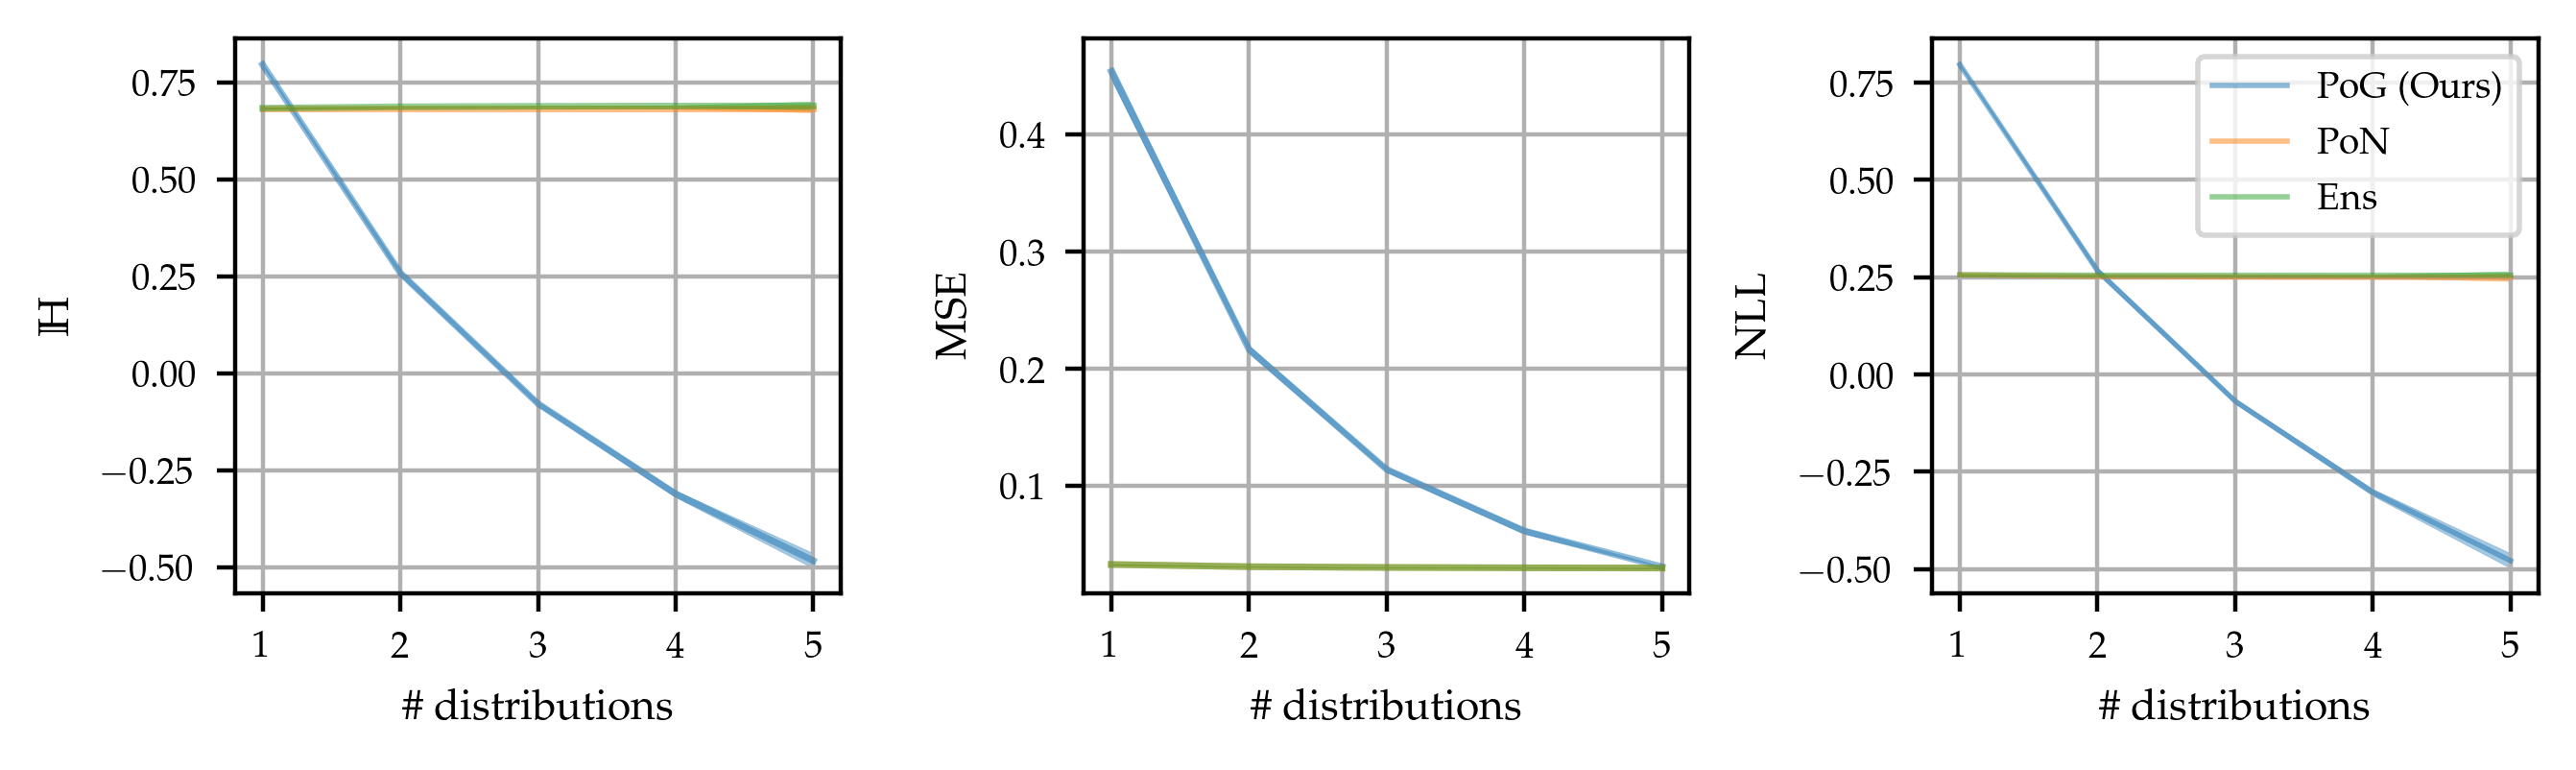

In [24]:
# matplotlib.style.use('default')
fig, axs = plt.subplots(1, 3, figsize=(text_width, text_width/3.3), dpi=dpi, sharey=False, sharex=True, layout='tight')

H_df = agg_df['H'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens']):
    x = H_df[H_df.model_name == model_name]['n_members']
    y = H_df[H_df.model_name == model_name]['mean']
    y_err = H_df[H_df.model_name == model_name]['std_err']

    axs[0].plot(x, y, c=f'C{i}', lw=1.25, alpha=0.5)
    axs[0].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[0].grid(0.3)
axs[0].set_ylabel('$\mathbb{H}$')
axs[0].set_xlabel('$\#$ distributions')
axs[0].set_xticks([1, 2, 3, 4, 5])

err_df = agg_df['mse'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens']):
    x = err_df[err_df.model_name == model_name]['n_members']
    y = err_df[err_df.model_name == model_name]['mean']
    y_err = err_df[err_df.model_name == model_name]['std_err']

    axs[1].plot(x, y, c=f'C{i}', lw=1.25, alpha=0.5)
    axs[1].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[1].grid(0.3)
axs[1].set_ylabel('MSE')
axs[1].set_xlabel('$\#$ distributions')
axs[1].set_xticks([1, 2, 3, 4, 5])

nll_df = agg_df[f'nll'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens']):
    x = nll_df[nll_df.model_name == model_name]['n_members']
    y = nll_df[nll_df.model_name == model_name]['mean']
    y_err = nll_df[nll_df.model_name == model_name]['std_err']

    axs[2].plot(x, y, c=f'C{i}', lw=1., alpha=0.5, label='PoG (Ours)' if model_name == 'PoG' else model_name)
    axs[2].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[2].grid(0.2)
axs[2].set_ylabel(f'NLL')
axs[2].set_xlabel('$\#$ distributions')
axs[2].set_xticks([1, 2, 3, 4, 5])
axs[2].legend()

plt.savefig(f'toy_entropy_err_nll_evolution.pdf', dpi=dpi, bbox_inches='tight')